# Лабораторная работа №1. Полносвязные нейронные сети прямого распространения

***Выполнила: Печкина Кристина, 932101гр.***

## Задание №1. Бинарный классификатор

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, balanced_accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras import layers
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical

### Работа с данными

In [4]:
df = pd.read_csv('diabetes_012_health_indicators_BRFSS2015.csv')
df.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [5]:
df.shape

(253680, 22)

In [6]:
#Пропусков нет
df.isnull().sum()/df.shape[0]

Diabetes_012            0.0
HighBP                  0.0
HighChol                0.0
CholCheck               0.0
BMI                     0.0
Smoker                  0.0
Stroke                  0.0
HeartDiseaseorAttack    0.0
PhysActivity            0.0
Fruits                  0.0
Veggies                 0.0
HvyAlcoholConsump       0.0
AnyHealthcare           0.0
NoDocbcCost             0.0
GenHlth                 0.0
MentHlth                0.0
PhysHlth                0.0
DiffWalk                0.0
Sex                     0.0
Age                     0.0
Education               0.0
Income                  0.0
dtype: float64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [8]:
df['Diabetes_012'] = df['Diabetes_012'].replace({2 : 1})  

In [9]:
df1 = df.drop_duplicates()

In [10]:
df1.shape

(229712, 22)

### Создание моделей
#### Base Model

Разделим датасет на три части: тренировочную (70%), тестовую (20%) и валидационную (10%).

In [12]:
X_train, X_rem, y_train, y_rem = train_test_split(df1.drop(['Diabetes_012'], axis=1), df1['Diabetes_012'],
                                                   train_size=0.7, random_state=77)

X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.66, random_state=77)

Создадим базовую модель нейронной сети, состоящую из 2 слоёв:
1. 4 нейрона, функция активации - ReLU
2. 1 нейрон, функция активации - Sigmoid

In [13]:
binary_classifier = Sequential(
    [
        layers.Dense(4, activation = 'relu', input_dim = X_train.shape[1]),
        layers.Dense(1, activation = 'sigmoid')
    ]
)
binary_classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 88        
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 93 (372.00 Byte)
Trainable params: 93 (372.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
binary_classifier.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = 'accuracy')

In [15]:
early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 10, mode = 'max', verbose = 1)
checkpoint = ModelCheckpoint('cancer_weights-{epoch:02d}-{val_accuracy:.3f}.hdf5',
                             monitor = 'val_accuracy', verbose = 1, mode = 'max',
                             save_best_only = True)
callbacks_list = [early_stop,checkpoint]

Зададим количество объектов в одном батче, равное 10, и число эпох, равное 100:

In [16]:
binary_class_history = binary_classifier.fit(X_train, y_train, batch_size = 10, validation_data = (X_valid, y_valid),
                                        callbacks = callbacks_list, epochs = 100)

Epoch 1/100
16079/16080 [============================>.] - ETA: 0s - loss: 0.4033 - accuracy: 0.8275
Epoch 1: val_accuracy improved from -inf to 0.83231, saving model to cancer_weights-01-0.832.hdf5
16080/16080 [==============================] - 49s 3ms/step - loss: 0.4033 - accuracy: 0.8275 - val_loss: 0.3833 - val_accuracy: 0.8323
Epoch 2/100
   65/16080 [..............................] - ETA: 38s - loss: 0.4001 - accuracy: 0.8385

c:\python\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16069/16080 [============================>.] - ETA: 0s - loss: 0.3861 - accuracy: 0.8300
Epoch 2: val_accuracy did not improve from 0.83231
16080/16080 [==============================] - 46s 3ms/step - loss: 0.3861 - accuracy: 0.8300 - val_loss: 0.3807 - val_accuracy: 0.8315
Epoch 3/100
16074/16080 [============================>.] - ETA: 0s - loss: 0.3823 - accuracy: 0.8309
Epoch 3: val_accuracy improved from 0.83231 to 0.83423, saving model to cancer_weights-03-0.834.hdf5
16080/16080 [==============================] - 50s 3ms/step - loss: 0.3824 - accuracy: 0.8309 - val_loss: 0.3759 - val_accuracy: 0.8342
Epoch 4/100
16079/16080 [============================>.] - ETA: 0s - loss: 0.3781 - accuracy: 0.8333
Epoch 4: val_accuracy improved from 0.83423 to 0.83470, saving model to cancer_weights-04-0.835.hdf5
16080/16080 [==============================] - 61s 4ms/step - loss: 0.3781 - accuracy: 0.8333 - val_loss: 0.3718 - val_accuracy: 0.8347
Epoch 5/100
16073/16080 [=======================

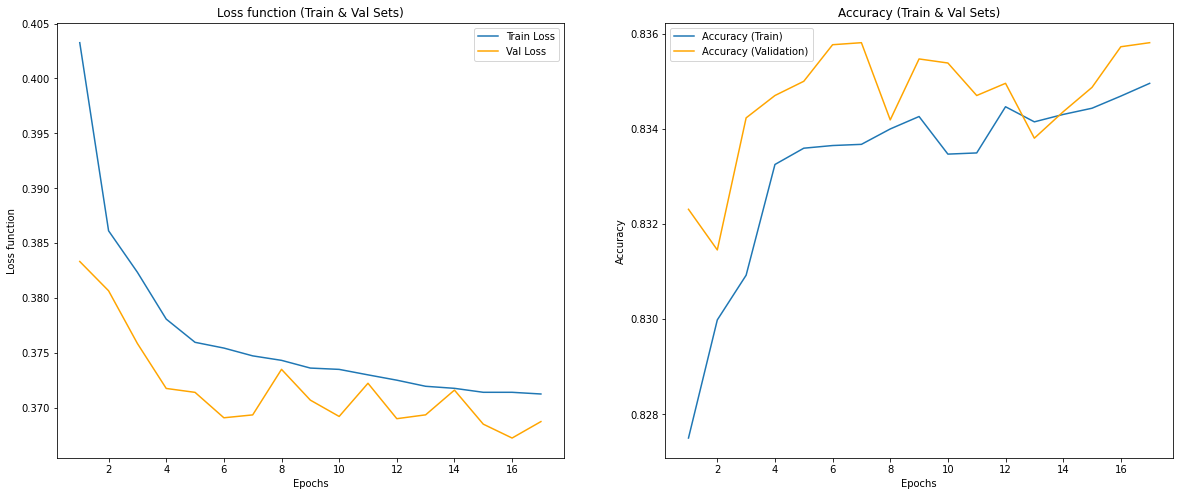

In [17]:
plt.figure(figsize=(20,8))
loss_function = binary_class_history.history['loss']
val_loss_function = binary_class_history.history['val_loss']
epochs = range(1,len(loss_function)+1)

acc = binary_class_history.history['accuracy']
val_acc = binary_class_history.history['val_accuracy']
epochs = range(1,len(acc)+1)

plt.subplot(1, 2, 1)
plt.title('Loss function (Train & Val Sets)')
plt.plot(epochs,loss_function,label='Train Loss')
plt.plot(epochs,val_loss_function,color='orange',label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy (Train & Val Sets)')
plt.plot(epochs,acc,label='Accuracy (Train)')
plt.plot(epochs,val_acc,color='orange',label='Accuracy (Validation)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [18]:
probs = binary_classifier.predict(X_test)[:,0]
truth = y_test

1422/1422 [==============================] - 3s 2ms/step


In [19]:
preds = (probs>0.5).astype(int)
preds

array([0, 0, 0, ..., 0, 0, 1])

In [20]:
df_metrics = pd.DataFrame(columns=['model', 'recall', 'precision', 'weighted_accuracy', 'auc'])
recall = round(recall_score(truth, preds), 4)
precision = round(precision_score(truth, preds), 4)
weighted_accuracy = round(balanced_accuracy_score(truth, preds), 4)
auc = round(roc_auc_score(truth, probs), 4)
df_metrics.loc[len(df_metrics.index)] = ['base_model', recall, precision, weighted_accuracy, auc] 

In [21]:
df_metrics

,model,recall,precision,weighted_accuracy,auc
0,base_model,0.1277,0.611,0.5556,0.8023


#### Second Model

Во второй модели увеличим количество слоёв, не увиличивая число нейронов и чередуя функции активации:
1. 4 нейрона, функция активации - ReLU
2. 4 нейрона, функция активации - Sigmoid
3. 4 нейрона, функция активации - ReLU
4. 4 нейрона, функция активации - Sigmoid
5. 2 нейрона, функция активации - ReLU
6. 1 нейрон, функция активации - Sigmoid

In [26]:
binary_classifier_2 = Sequential(
    [
        layers.Dense(4, activation = 'relu', input_dim = X_train.shape[1]),
        layers.Dense(4, activation = 'sigmoid'),
        layers.Dense(4, activation = 'relu'),
        layers.Dense(4, activation = 'sigmoid'),
        layers.Dense(2, activation = 'relu'),
        layers.Dense(1, activation = 'sigmoid')
    ]
)
binary_classifier_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 4)                 88        
                                                                 
 dense_9 (Dense)             (None, 4)                 20        
                                                                 
 dense_10 (Dense)            (None, 4)                 20        
                                                                 
 dense_11 (Dense)            (None, 4)                 20        
                                                                 
 dense_12 (Dense)            (None, 2)                 10        
                                                                 
 dense_13 (Dense)            (None, 1)                 3         
                                                                 
Total params: 161 (644.00 Byte)
Trainable params: 161 

In [27]:
binary_classifier_2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = 'accuracy')

In [28]:
early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 10, mode = 'max', verbose =1)
checkpoint = ModelCheckpoint('cancer2_weights-{epoch:02d}-{val_accuracy:.3f}.hdf5',
                             monitor = 'val_accuracy', verbose = 1, mode = 'max',
                             save_best_only = True)
callbacks_list = [early_stop,checkpoint]

In [29]:
binary_class_history = binary_classifier_2.fit(X_train, y_train, batch_size = 10, validation_data = (X_valid, y_valid),
                                        callbacks = callbacks_list, epochs = 100)

Epoch 1/100
16069/16080 [============================>.] - ETA: 0s - loss: 0.3903 - accuracy: 0.8279
Epoch 1: val_accuracy improved from -inf to 0.82949, saving model to cancer2_weights-01-0.829.hdf5
16080/16080 [==============================] - 67s 4ms/step - loss: 0.3903 - accuracy: 0.8279 - val_loss: 0.3718 - val_accuracy: 0.8295
Epoch 2/100
   17/16080 [..............................] - ETA: 52s - loss: 0.4067 - accuracy: 0.8235 

c:\python\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16074/16080 [============================>.] - ETA: 0s - loss: 0.3748 - accuracy: 0.8330
Epoch 2: val_accuracy improved from 0.82949 to 0.83589, saving model to cancer2_weights-02-0.836.hdf5
16080/16080 [==============================] - 62s 4ms/step - loss: 0.3749 - accuracy: 0.8330 - val_loss: 0.3687 - val_accuracy: 0.8359
Epoch 3/100
16079/16080 [============================>.] - ETA: 0s - loss: 0.3732 - accuracy: 0.8339
Epoch 3: val_accuracy improved from 0.83589 to 0.83636, saving model to cancer2_weights-03-0.836.hdf5
16080/16080 [==============================] - 64s 4ms/step - loss: 0.3732 - accuracy: 0.8339 - val_loss: 0.3681 - val_accuracy: 0.8364
Epoch 4/100
16077/16080 [============================>.] - ETA: 0s - loss: 0.3724 - accuracy: 0.8344
Epoch 4: val_accuracy did not improve from 0.83636
16080/16080 [==============================] - 65s 4ms/step - loss: 0.3723 - accuracy: 0.8344 - val_loss: 0.3679 - val_accuracy: 0.8359
Epoch 5/100
16070/16080 [=====================

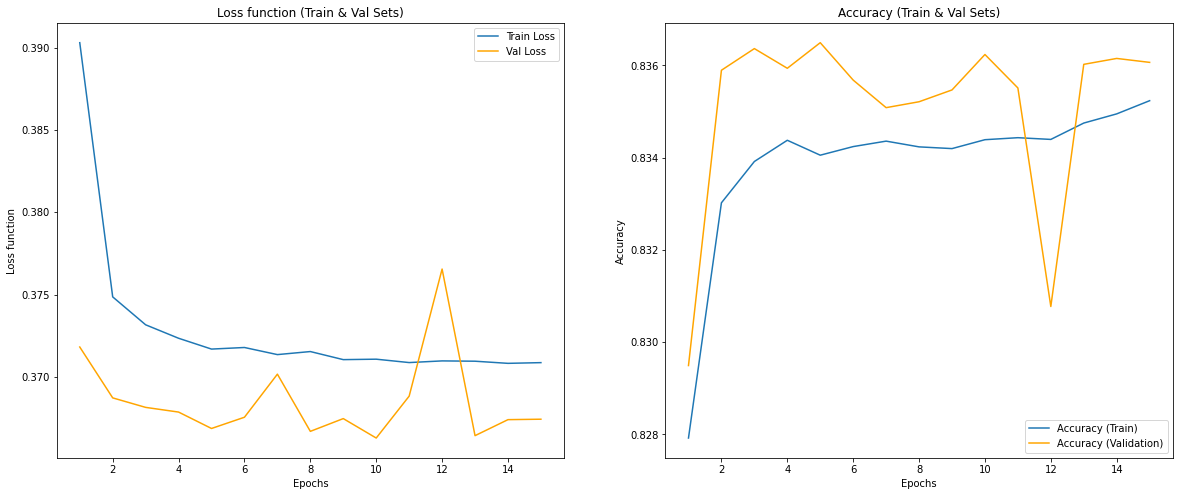

In [30]:
plt.figure(figsize=(20,8))
loss_function = binary_class_history.history['loss']
val_loss_function = binary_class_history.history['val_loss']
epochs = range(1,len(loss_function)+1)

acc = binary_class_history.history['accuracy']
val_acc = binary_class_history.history['val_accuracy']
epochs = range(1,len(acc)+1)

plt.subplot(1, 2, 1)
plt.title('Loss function (Train & Val Sets)')
plt.plot(epochs,loss_function,label='Train Loss')
plt.plot(epochs,val_loss_function,color='orange',label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy (Train & Val Sets)')
plt.plot(epochs,acc,label='Accuracy (Train)')
plt.plot(epochs,val_acc,color='orange',label='Accuracy (Validation)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [31]:
probs = binary_classifier_2.predict(X_test)[:,0]
truth = y_test

1422/1422 [==============================] - 3s 2ms/step


In [32]:
preds = (probs>0.5).astype(int)
preds

array([0, 0, 0, ..., 0, 0, 1])

In [33]:
recall = round(recall_score(truth, preds), 4)
precision = round(precision_score(truth, preds), 4)
weighted_accuracy = round(balanced_accuracy_score(truth, preds), 4)
auc = round(roc_auc_score(truth, probs), 4)
df_metrics.loc[len(df_metrics.index)] = ['seсond_model', recall, precision, weighted_accuracy, auc] 

In [34]:
df_metrics

,model,recall,precision,weighted_accuracy,auc
0,base_model,0.1277,0.6110,0.5556,0.8023
1,seсond_model,0.1958,0.5608,0.5823,0.8032


#### Third Model

Увеличим количество нейронов на каждом слое, кроме последнего:
1. 64 нейрона, функция активации - ReLU
2. 64 нейрона, функция активации - Sigmoid
3. 32 нейрона, функция активации - ReLU
4. 16 нейронов, функция активации - Sigmoid
5. 8 нейронов, функция активации - ReLU
6. 1 нейрон, функция активации - Sigmoid

In [35]:
binary_classifier_3 = Sequential(
    [
        layers.Dense(64, activation = 'relu', input_dim = X_train.shape[1]),
        layers.Dense(64, activation = 'sigmoid'),
        layers.Dense(32, activation = 'relu'),
        layers.Dense(16, activation = 'sigmoid'),
        layers.Dense(8, activation = 'relu'),
        layers.Dense(1, activation = 'sigmoid')
    ]
)
binary_classifier_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 64)                1408      
                                                                 
 dense_15 (Dense)            (None, 64)                4160      
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 dense_17 (Dense)            (None, 16)                528       
                                                                 
 dense_18 (Dense)            (None, 8)                 136       
                                                                 
 dense_19 (Dense)            (None, 1)                 9         
                                                                 
Total params: 8321 (32.50 KB)
Trainable params: 8321 (

In [36]:
binary_classifier_3.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = 'accuracy')

In [37]:
early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 10, mode = 'max', verbose =1)
checkpoint = ModelCheckpoint('cancer3_weights-{epoch:02d}-{val_accuracy:.3f}.hdf5',
                             monitor = 'val_accuracy', verbose = 1, mode = 'max',
                             save_best_only = True)
callbacks_list = [early_stop,checkpoint]

Увеличим число объектов в одном батче в 10 раз и уменьшим количество эпох в 2 раза:

In [38]:
binary_class_history = binary_classifier_3.fit(X_train, y_train, batch_size = 100, validation_data = (X_valid, y_valid),
                                        callbacks = callbacks_list, epochs = 50)

Epoch 1/50
1605/1608 [============================>.] - ETA: 0s - loss: 0.3876 - accuracy: 0.8290
Epoch 1: val_accuracy improved from -inf to 0.83606, saving model to cancer3_weights-01-0.836.hdf5
1608/1608 [==============================] - 9s 4ms/step - loss: 0.3877 - accuracy: 0.8290 - val_loss: 0.3737 - val_accuracy: 0.8361
Epoch 2/50
  16/1608 [..............................] - ETA: 5s - loss: 0.3731 - accuracy: 0.8219

c:\python\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1599/1608 [============================>.] - ETA: 0s - loss: 0.3740 - accuracy: 0.8331
Epoch 2: val_accuracy improved from 0.83606 to 0.83641, saving model to cancer3_weights-02-0.836.hdf5
1608/1608 [==============================] - 6s 4ms/step - loss: 0.3739 - accuracy: 0.8332 - val_loss: 0.3701 - val_accuracy: 0.8364
Epoch 3/50
1604/1608 [============================>.] - ETA: 0s - loss: 0.3726 - accuracy: 0.8342
Epoch 3: val_accuracy improved from 0.83641 to 0.83756, saving model to cancer3_weights-03-0.838.hdf5
1608/1608 [==============================] - 7s 4ms/step - loss: 0.3727 - accuracy: 0.8342 - val_loss: 0.3665 - val_accuracy: 0.8376
Epoch 4/50
1601/1608 [============================>.] - ETA: 0s - loss: 0.3710 - accuracy: 0.8346
Epoch 4: val_accuracy improved from 0.83756 to 0.83760, saving model to cancer3_weights-04-0.838.hdf5
1608/1608 [==============================] - 6s 4ms/step - loss: 0.3711 - accuracy: 0.8346 - val_loss: 0.3685 - val_accuracy: 0.8376
Epoch 5/50
1

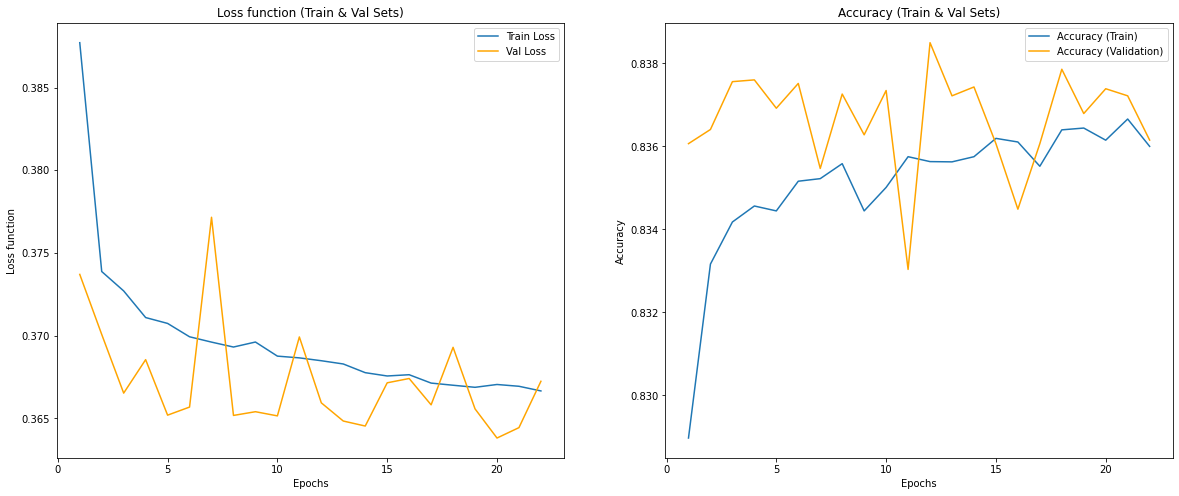

In [39]:
plt.figure(figsize=(20,8))
loss_function = binary_class_history.history['loss']
val_loss_function = binary_class_history.history['val_loss']
epochs = range(1,len(loss_function)+1)

acc = binary_class_history.history['accuracy']
val_acc = binary_class_history.history['val_accuracy']
epochs = range(1,len(acc)+1)

plt.subplot(1, 2, 1)
plt.title('Loss function (Train & Val Sets)')
plt.plot(epochs,loss_function,label='Train Loss')
plt.plot(epochs,val_loss_function,color='orange',label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy (Train & Val Sets)')
plt.plot(epochs,acc,label='Accuracy (Train)')
plt.plot(epochs,val_acc,color='orange',label='Accuracy (Validation)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [40]:
probs = binary_classifier_3.predict(X_test)[:,0]
truth = y_test

1422/1422 [==============================] - 3s 2ms/step


In [41]:
preds = (probs>0.5).astype(int)
preds

array([0, 0, 0, ..., 0, 0, 0])

In [42]:
recall = round(recall_score(truth, preds), 4)
precision = round(precision_score(truth, preds), 4)
weighted_accuracy = round(balanced_accuracy_score(truth, preds), 4)
auc = round(roc_auc_score(truth, probs), 4)
df_metrics.loc[len(df_metrics.index)] = ['third_model', recall, precision, weighted_accuracy, auc] 

In [43]:
df_metrics

,model,recall,precision,weighted_accuracy,auc
0,base_model,0.1277,0.6110,0.5556,0.8023
1,seсond_model,0.1958,0.5608,0.5823,0.8032
2,third_model,0.1830,0.5674,0.5774,0.8030


#### Fourth Model

Добавим Dropout(0.1) после нескольких первых слоёв:

In [49]:
binary_classifier_4 = Sequential(
    [
        layers.Dense(64, activation = 'relu', input_dim = X_train.shape[1]),
        layers.Dropout(0.1),
        layers.Dense(64, activation = 'sigmoid'),
        layers.Dropout(0.1),
        layers.Dense(32, activation = 'relu'),
        layers.Dropout(0.1),
        layers.Dense(16, activation = 'sigmoid'),
        layers.Dense(8, activation = 'relu'),
        layers.Dense(1, activation = 'sigmoid')
    ]
)
binary_classifier_4.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 64)                1408      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_27 (Dense)            (None, 64)                4160      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_28 (Dense)            (None, 32)                2080      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_29 (Dense)            (None, 16)               

Изменим процедуру оптимизации на SGD:

In [50]:
binary_classifier_4.compile(loss = 'binary_crossentropy', optimizer = 'sgd', metrics = 'accuracy')

In [51]:
early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 10, mode = 'max', verbose =1)
checkpoint = ModelCheckpoint('cancer4_weights-{epoch:02d}-{val_accuracy:.3f}.hdf5',
                             monitor = 'val_accuracy', verbose = 1, mode = 'max',
                             save_best_only = True)
callbacks_list = [early_stop,checkpoint]

In [52]:
binary_class_history = binary_classifier_4.fit(X_train, y_train, batch_size = 100, validation_data = (X_valid, y_valid),
                                        callbacks = callbacks_list, epochs = 50)

Epoch 1/50
1599/1608 [============================>.] - ETA: 0s - loss: 0.4607 - accuracy: 0.8263
Epoch 1: val_accuracy improved from -inf to 0.82663, saving model to cancer_weights-01-0.827.hdf5
1608/1608 [==============================] - 4s 2ms/step - loss: 0.4606 - accuracy: 0.8264 - val_loss: 0.4508 - val_accuracy: 0.8266
Epoch 2/50
  55/1608 [>.............................] - ETA: 2s - loss: 0.4408 - accuracy: 0.8351

c:\python\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1595/1608 [============================>.] - ETA: 0s - loss: 0.4471 - accuracy: 0.8265
Epoch 2: val_accuracy did not improve from 0.82663
1608/1608 [==============================] - 3s 2ms/step - loss: 0.4472 - accuracy: 0.8264 - val_loss: 0.4313 - val_accuracy: 0.8266
Epoch 3/50
1597/1608 [============================>.] - ETA: 0s - loss: 0.4300 - accuracy: 0.8264
Epoch 3: val_accuracy did not improve from 0.82663
1608/1608 [==============================] - 3s 2ms/step - loss: 0.4300 - accuracy: 0.8264 - val_loss: 0.4126 - val_accuracy: 0.8266
Epoch 4/50
1592/1608 [============================>.] - ETA: 0s - loss: 0.4178 - accuracy: 0.8264
Epoch 4: val_accuracy did not improve from 0.82663
1608/1608 [==============================] - 3s 2ms/step - loss: 0.4178 - accuracy: 0.8264 - val_loss: 0.4037 - val_accuracy: 0.8266
Epoch 5/50
1587/1608 [============================>.] - ETA: 0s - loss: 0.4109 - accuracy: 0.8264
Epoch 5: val_accuracy did not improve from 0.82663
1608/1608 [=====

1608/1608 [==============================] - 3s 2ms/step - loss: 0.3811 - accuracy: 0.8311 - val_loss: 0.3707 - val_accuracy: 0.8356
Epoch 30/50
1588/1608 [============================>.] - ETA: 0s - loss: 0.3802 - accuracy: 0.8310
Epoch 30: val_accuracy improved from 0.83619 to 0.83624, saving model to cancer_weights-30-0.836.hdf5
1608/1608 [==============================] - 3s 2ms/step - loss: 0.3802 - accuracy: 0.8310 - val_loss: 0.3706 - val_accuracy: 0.8362
Epoch 31/50
1606/1608 [============================>.] - ETA: 0s - loss: 0.3792 - accuracy: 0.8321
Epoch 31: val_accuracy did not improve from 0.83624
1608/1608 [==============================] - 3s 2ms/step - loss: 0.3792 - accuracy: 0.8321 - val_loss: 0.3720 - val_accuracy: 0.8347
Epoch 32/50
1602/1608 [============================>.] - ETA: 0s - loss: 0.3798 - accuracy: 0.8314
Epoch 32: val_accuracy did not improve from 0.83624
1608/1608 [==============================] - 3s 2ms/step - loss: 0.3798 - accuracy: 0.8314 - val_l

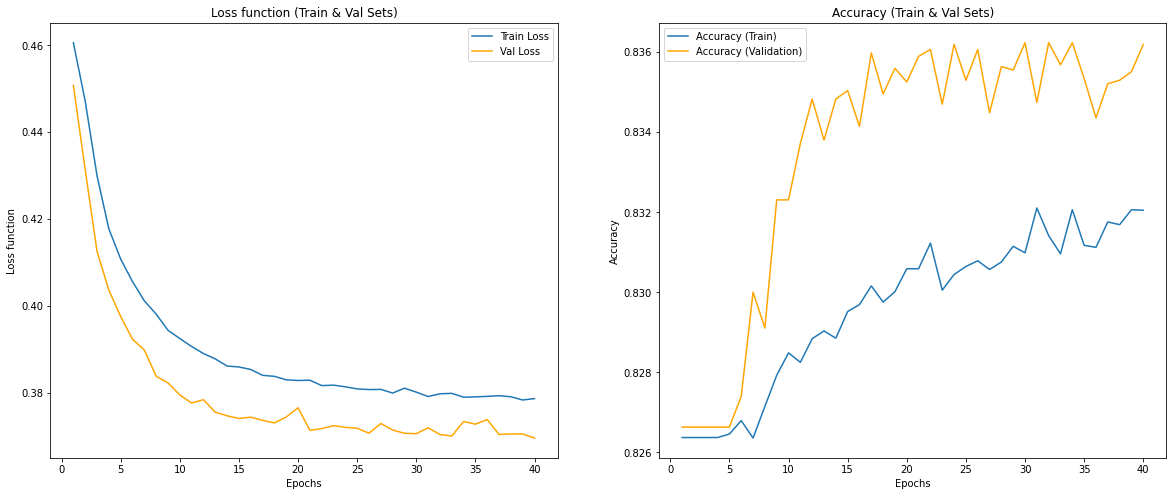

In [53]:
plt.figure(figsize=(20,8))
loss_function = binary_class_history.history['loss']
val_loss_function = binary_class_history.history['val_loss']
epochs = range(1,len(loss_function)+1)

acc = binary_class_history.history['accuracy']
val_acc = binary_class_history.history['val_accuracy']
epochs = range(1,len(acc)+1)

plt.subplot(1, 2, 1)
plt.title('Loss function (Train & Val Sets)')
plt.plot(epochs,loss_function,label='Train Loss')
plt.plot(epochs,val_loss_function,color='orange',label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy (Train & Val Sets)')
plt.plot(epochs,acc,label='Accuracy (Train)')
plt.plot(epochs,val_acc,color='orange',label='Accuracy (Validation)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [54]:
probs = binary_classifier_4.predict(X_test)[:,0]
truth = y_test

1422/1422 [==============================] - 1s 860us/step


In [55]:
preds = (probs>0.5).astype(int)
preds

array([0, 0, 0, ..., 0, 0, 1])

In [56]:
recall = round(recall_score(truth, preds), 4)
precision = round(precision_score(truth, preds), 4)
weighted_accuracy = round(balanced_accuracy_score(truth, preds), 4)
auc = round(roc_auc_score(truth, probs), 4)
df_metrics.loc[len(df_metrics.index)] = ['fourth_model', recall, precision, weighted_accuracy, auc] 

In [57]:
df_metrics

,model,recall,precision,weighted_accuracy,auc
0,base_model,0.1277,0.6110,0.5556,0.8023
1,seсond_model,0.1958,0.5608,0.5823,0.8032
2,third_model,0.1830,0.5674,0.5774,0.8030
3,fourth_model,0.1476,0.5904,0.5634,0.7990


Анализируя полученные метрики 4-х моделей, можно сделать вывод, что наилучшим бинарным классификатором является Second Model.

Построим ROC-кривую для данной модели:

In [61]:
probs_2 = binary_classifier_2.predict(X_test)[:,0]
truth = y_test

1422/1422 [==============================] - 1s 816us/step


In [62]:
preds_2 = (probs_2>0.5).astype(int)
preds_2

array([0, 0, 0, ..., 0, 0, 1])

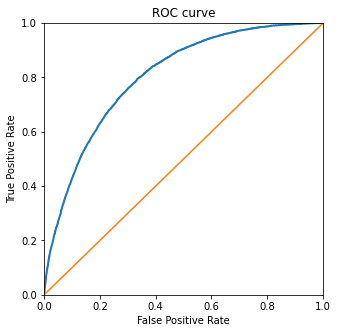

In [64]:
fpr, tpr, thresholds = roc_curve(truth, probs_2, pos_label=1)
lw = 2
plt.rcParams['figure.figsize']=(5,5)
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

plt.show()

### Вывод

Набор данных 'diabetes_012_health_indicators_BRFSS2015.csv' не содержал пропущенных значений, но в нем присутствовало несколько дубликатов, которые были удалены. Значения 2 в таргетном столбце были преобразованы в 1, так как этого требовало условие задания.

Среди четырёх моделей бинарных классификаторов лучше всего сработала Second Model. В ней увеличено число слоёв по сравнению с Base Model, но не увеличено число нейронов на каждом слое.

Оценка качества бинарных классификаторов происходила по следующим метрикам: Recall, Precision, Weighted Accuracy и AUC. Эти показатели у Second Model в среднем выше, чем у остальных моделей.

## Задание №2. Многоклассовый классификатор

### Работа с данными

In [3]:
df = pd.read_csv('bodyPerformance.csv')
df.head()

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,27.0,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C
1,25.0,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A
2,31.0,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C
3,32.0,M,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B
4,28.0,M,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B


In [4]:
df.shape

(13393, 12)

In [5]:
#Пропусков нет
df.isnull().sum()/df.shape[0]

age                        0.0
gender                     0.0
height_cm                  0.0
weight_kg                  0.0
body fat_%                 0.0
diastolic                  0.0
systolic                   0.0
gripForce                  0.0
sit and bend forward_cm    0.0
sit-ups counts             0.0
broad jump_cm              0.0
class                      0.0
dtype: float64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13393 entries, 0 to 13392
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      13393 non-null  float64
 1   gender                   13393 non-null  object 
 2   height_cm                13393 non-null  float64
 3   weight_kg                13393 non-null  float64
 4   body fat_%               13393 non-null  float64
 5   diastolic                13393 non-null  float64
 6   systolic                 13393 non-null  float64
 7   gripForce                13393 non-null  float64
 8   sit and bend forward_cm  13393 non-null  float64
 9   sit-ups counts           13393 non-null  float64
 10  broad jump_cm            13393 non-null  float64
 11  class                    13393 non-null  object 
dtypes: float64(10), object(2)
memory usage: 1.2+ MB


In [7]:
print(df['gender'].unique())
print(df['class'].unique())

['M' 'F']
['C' 'A' 'B' 'D']


Закодируем значения в столбцах типа object:

In [8]:
df['gender'] = df['gender'].replace({'M' : 1, 'F' : 0}) 
df = df.rename(columns={'gender' : 'is_male'})
df['class'] = df['class'].replace({'A' : 0, 'B' : 1, 'C' : 2, 'D' : 3}) 

In [9]:
df1 = df.drop_duplicates()

In [10]:
df1.shape

(13392, 12)

In [11]:
df1.head()

,age,is_male,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,27.0,1,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,2
1,25.0,1,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,0
2,31.0,1,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,2
3,32.0,1,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,1
4,28.0,1,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,1


In [12]:
X = df1.drop(['class'],axis=1)
y = df1['class']

In [15]:
min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)

Разделим датасет на три части: тренировочную (70%), тестовую (20%) и валидационную (10%).

In [16]:
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.7, random_state=77)

X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.66, random_state=77)

In [17]:
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)
y_test = to_categorical(y_test)

### Создание моделей
#### Base Model

Создадим базовую модель нейронной сети, состоящую из 2 слоёв:
1. 8 нейронов, функция активации - ReLU
2. 4 нейрона, функция активации - Softmax

In [18]:
multi_classifier = Sequential(
    [
        layers.Dense(8, activation = 'relu', input_dim = X_train.shape[1]),
        layers.Dense(4, activation = 'softmax')
    ]
)
multi_classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 96        
                                                                 
 dense_1 (Dense)             (None, 4)                 36        
                                                                 
Total params: 132 (528.00 Byte)
Trainable params: 132 (528.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
multi_classifier.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = 'accuracy')

In [20]:
early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 10, mode = 'max', verbose =1)
checkpoint = ModelCheckpoint('body_weights-{epoch:02d}-{val_r2:.3f}.hdf5',
                             monitor = 'val_accuracy', verbose = 1, mode = 'max',
                             save_best_only = True)
callbacks_list = [early_stop,checkpoint]

Зададим количество объектов в одном батче, равное 10, и число эпох, равное 100:

In [21]:
multi_class_history = multi_classifier.fit(X_train, y_train, batch_size = 10, validation_data = (X_valid, y_valid),
                                        callbacks = callbacks_list, epochs = 100)

Epoch 1/100
925/938 [============================>.] - ETA: 0s - loss: 1.3745 - accuracy: 0.3315
Epoch 1: val_accuracy improved from -inf to 0.33821, saving model to body_weights-01-0.338.hdf5
938/938 [==============================] - 2s 2ms/step - loss: 1.3735 - accuracy: 0.3322 - val_loss: 1.3205 - val_accuracy: 0.3382
Epoch 2/100
106/938 [==>...........................] - ETA: 1s - loss: 1.3087 - accuracy: 0.3981

c:\python\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


906/938 [===========================>..] - ETA: 0s - loss: 1.2584 - accuracy: 0.4546
Epoch 2: val_accuracy improved from 0.33821 to 0.46047, saving model to body_weights-02-0.460.hdf5
938/938 [==============================] - 1s 2ms/step - loss: 1.2567 - accuracy: 0.4566 - val_loss: 1.2229 - val_accuracy: 0.4605
Epoch 3/100
912/938 [============================>.] - ETA: 0s - loss: 1.1550 - accuracy: 0.4961
Epoch 3: val_accuracy improved from 0.46047 to 0.52343, saving model to body_weights-03-0.523.hdf5
938/938 [==============================] - 1s 2ms/step - loss: 1.1541 - accuracy: 0.4966 - val_loss: 1.1214 - val_accuracy: 0.5234
Epoch 4/100
925/938 [============================>.] - ETA: 0s - loss: 1.0726 - accuracy: 0.5234
Epoch 4: val_accuracy improved from 0.52343 to 0.53807, saving model to body_weights-04-0.538.hdf5
938/938 [==============================] - 1s 1ms/step - loss: 1.0721 - accuracy: 0.5239 - val_loss: 1.0686 - val_accuracy: 0.5381
Epoch 5/100
914/938 [==========

938/938 [==============================] - 1s 2ms/step - loss: 0.8917 - accuracy: 0.5985 - val_loss: 0.9202 - val_accuracy: 0.6142
Epoch 29/100
920/938 [============================>.] - ETA: 0s - loss: 0.8897 - accuracy: 0.5978
Epoch 29: val_accuracy did not improve from 0.61420
938/938 [==============================] - 2s 2ms/step - loss: 0.8900 - accuracy: 0.5980 - val_loss: 0.9157 - val_accuracy: 0.6010
Epoch 30/100
923/938 [============================>.] - ETA: 0s - loss: 0.8879 - accuracy: 0.6007
Epoch 30: val_accuracy improved from 0.61420 to 0.62299, saving model to body_weights-30-0.623.hdf5
938/938 [==============================] - 1s 1ms/step - loss: 0.8884 - accuracy: 0.6006 - val_loss: 0.9274 - val_accuracy: 0.6230
Epoch 31/100
916/938 [============================>.] - ETA: 0s - loss: 0.8864 - accuracy: 0.6021
Epoch 31: val_accuracy did not improve from 0.62299
938/938 [==============================] - 1s 1ms/step - loss: 0.8862 - accuracy: 0.6023 - val_loss: 0.9102 -

Epoch 57/100
906/938 [===========================>..] - ETA: 0s - loss: 0.8643 - accuracy: 0.6103
Epoch 57: val_accuracy did not improve from 0.64129
938/938 [==============================] - 1s 1ms/step - loss: 0.8631 - accuracy: 0.6115 - val_loss: 0.8882 - val_accuracy: 0.6113
Epoch 58/100
892/938 [===========================>..] - ETA: 0s - loss: 0.8637 - accuracy: 0.6119
Epoch 58: val_accuracy did not improve from 0.64129
938/938 [==============================] - 1s 1ms/step - loss: 0.8620 - accuracy: 0.6129 - val_loss: 0.8941 - val_accuracy: 0.6054
Epoch 58: early stopping


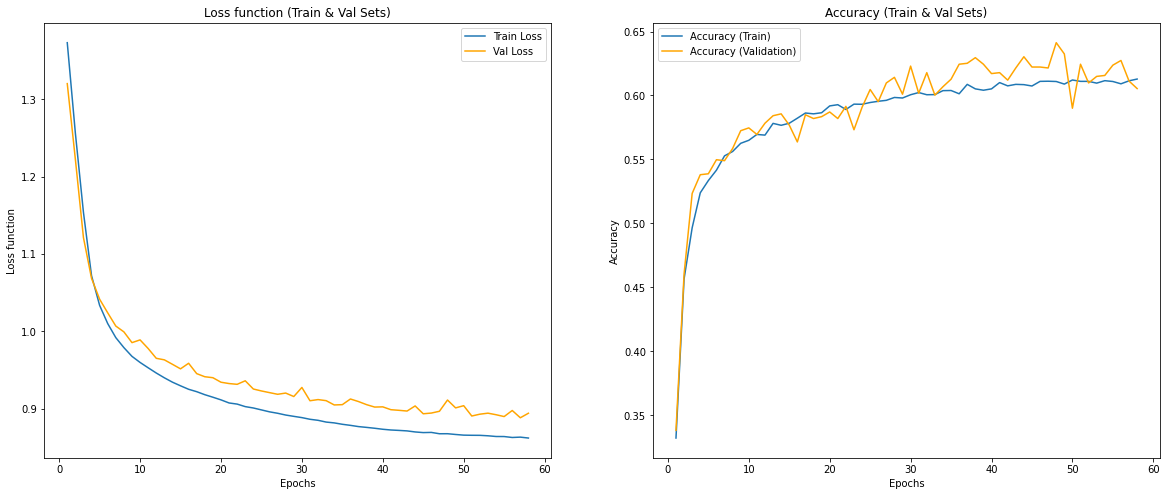

In [22]:
plt.figure(figsize=(20,8))
loss_function = multi_class_history.history['loss']
val_loss_function = multi_class_history.history['val_loss']
epochs = range(1,len(loss_function)+1)

acc = multi_class_history.history['accuracy']
val_acc = multi_class_history.history['val_accuracy']
epochs = range(1,len(acc)+1)

plt.subplot(1, 2, 1)
plt.title('Loss function (Train & Val Sets)')
plt.plot(epochs,loss_function,label='Train Loss')
plt.plot(epochs,val_loss_function,color='orange',label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy (Train & Val Sets)')
plt.plot(epochs,acc,label='Accuracy (Train)')
plt.plot(epochs,val_acc,color='orange',label='Accuracy (Validation)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [36]:
probs = multi_classifier.predict(X_test)
truth = np.argmax(y_test, axis=1)

83/83 [==============================] - 0s 1ms/step


In [37]:
predicted = np.argmax(probs, axis=1)

In [44]:
df_metrics_multi = pd.DataFrame(columns=['model', 'recall', 'precision', 'weighted_accuracy', 'auc'])
recall = round(recall_score(truth, predicted, average='macro'), 4)
precision = round(precision_score(truth, predicted, average='macro'), 4)
weighted_accuracy = round(balanced_accuracy_score(truth, predicted), 4)
auc = round(roc_auc_score(truth, probs, average='macro', multi_class='ovr'), 4)
df_metrics_multi.loc[len(df_metrics_multi.index)] = ['base_model', recall, precision, weighted_accuracy, auc] 

In [45]:
df_metrics_multi

,model,recall,precision,weighted_accuracy,auc
0,base_model,0.6025,0.5948,0.6025,0.85


#### Second Model

Во второй модели увеличим количество слоёв, не увиличивая число нейронов и чередуя функции активации:
1. 8 нейронов, функция активации - ReLU
2. 8 нейронов, функция активации - Sigmoid
3. 8 нейронов, функция активации - ReLU
4. 8 нейронов, функция активации - Sigmoid
5. 8 нейронов, функция активации - ReLU
6. 4 нейрона, функция активации - Softmax

In [51]:
multi_classifier_2 = Sequential(
    [
        layers.Dense(8, activation = 'relu', input_dim = X_train.shape[1]),
        layers.Dense(8, activation = 'sigmoid'),
        layers.Dense(8, activation = 'relu'),
        layers.Dense(8, activation = 'sigmoid'),
        layers.Dense(8, activation = 'relu'),
        layers.Dense(4, activation = 'softmax')
    ]
)
multi_classifier_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 8)                 96        
                                                                 
 dense_9 (Dense)             (None, 8)                 72        
                                                                 
 dense_10 (Dense)            (None, 8)                 72        
                                                                 
 dense_11 (Dense)            (None, 8)                 72        
                                                                 
 dense_12 (Dense)            (None, 8)                 72        
                                                                 
 dense_13 (Dense)            (None, 4)                 36        
                                                                 
Total params: 420 (1.64 KB)
Trainable params: 420 (1.6

In [52]:
multi_classifier_2.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = 'accuracy')

In [53]:
early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 10, mode = 'max', verbose = 1)
checkpoint = ModelCheckpoint('body_weights-{epoch:02d}-{val_accuracy:.3f}.hdf5',
                             monitor = 'val_accuracy', verbose = 1, mode = 'max',
                             save_best_only = True)
callbacks_list = [early_stop,checkpoint]

In [54]:
multi_class_history = multi_classifier_2.fit(X_train, y_train, batch_size = 10, validation_data = (X_valid, y_valid),
                                        callbacks = callbacks_list, epochs = 100)

Epoch 1/100
919/938 [============================>.] - ETA: 0s - loss: 1.3838 - accuracy: 0.2845
Epoch 1: val_accuracy improved from -inf to 0.37701, saving model to body_weights-01-0.377.hdf5
938/938 [==============================] - 3s 2ms/step - loss: 1.3833 - accuracy: 0.2866 - val_loss: 1.3539 - val_accuracy: 0.3770
Epoch 2/100
927/938 [============================>.] - ETA: 0s - loss: 1.1575 - accuracy: 0.4735
Epoch 2: val_accuracy improved from 0.37701 to 0.52123, saving model to body_weights-02-0.521.hdf5
938/938 [==============================] - 2s 2ms/step - loss: 1.1569 - accuracy: 0.4738 - val_loss: 1.0449 - val_accuracy: 0.5212
Epoch 3/100
933/938 [============================>.] - ETA: 0s - loss: 0.9909 - accuracy: 0.5527
Epoch 3: val_accuracy improved from 0.52123 to 0.55710, saving model to body_weights-03-0.557.hdf5
938/938 [==============================] - 2s 2ms/step - loss: 0.9907 - accuracy: 0.5526 - val_loss: 0.9958 - val_accuracy: 0.5571
Epoch 4/100
920/938 [=

938/938 [==============================] - 2s 2ms/step - loss: 0.8553 - accuracy: 0.6068 - val_loss: 0.8712 - val_accuracy: 0.6201
Epoch 29/100
937/938 [============================>.] - ETA: 0s - loss: 0.8534 - accuracy: 0.6079
Epoch 29: val_accuracy did not improve from 0.64788
938/938 [==============================] - 2s 2ms/step - loss: 0.8534 - accuracy: 0.6079 - val_loss: 0.8820 - val_accuracy: 0.6340
Epoch 29: early stopping


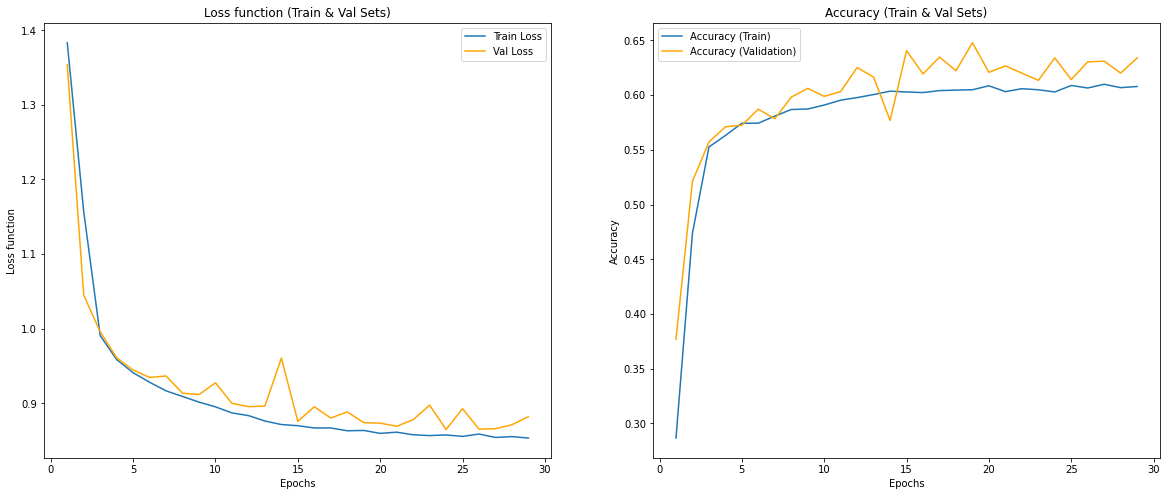

In [55]:
plt.figure(figsize=(20,8))
loss_function = multi_class_history.history['loss']
val_loss_function = multi_class_history.history['val_loss']
epochs = range(1,len(loss_function)+1)

acc = multi_class_history.history['accuracy']
val_acc = multi_class_history.history['val_accuracy']
epochs = range(1,len(acc)+1)

plt.subplot(1, 2, 1)
plt.title('Loss function (Train & Val Sets)')
plt.plot(epochs,loss_function,label='Train Loss')
plt.plot(epochs,val_loss_function,color='orange',label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy (Train & Val Sets)')
plt.plot(epochs,acc,label='Accuracy (Train)')
plt.plot(epochs,val_acc,color='orange',label='Accuracy (Validation)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [56]:
probs = multi_classifier_2.predict(X_test)
truth = np.argmax(y_test, axis=1)

83/83 [==============================] - 0s 1ms/step


In [57]:
predicted = np.argmax(probs, axis=1)

In [58]:
recall = round(recall_score(truth, predicted, average='macro'), 4)
precision = round(precision_score(truth, predicted, average='macro'), 4)
weighted_accuracy = round(balanced_accuracy_score(truth, predicted), 4)
auc = round(roc_auc_score(truth, probs, average='macro', multi_class='ovr'), 4)
df_metrics_multi.loc[len(df_metrics_multi.index)] = ['second_model', recall, precision, weighted_accuracy, auc] 

In [59]:
df_metrics_multi

,model,recall,precision,weighted_accuracy,auc
0,base_model,0.6025,0.5948,0.6025,0.8500
1,second_model,0.6354,0.6503,0.6354,0.8594


#### Third Model

Увеличим количество нейронов на каждом слое, кроме двух последних:
1. 64 нейрона, функция активации - ReLU
2. 64 нейрона, функция активации - Sigmoid
3. 32 нейрона, функция активации - ReLU
4. 16 нейронов, функция активации - Sigmoid
5. 8 нейронов, функция активации - ReLU
6. 4 нейрона, функция активации - Softmax

In [60]:
multi_classifier_3 = Sequential(
    [
        layers.Dense(64, activation = 'relu', input_dim = X_train.shape[1]),
        layers.Dense(64, activation = 'sigmoid'),
        layers.Dense(32, activation = 'relu'),
        layers.Dense(16, activation = 'sigmoid'),
        layers.Dense(8, activation = 'relu'),
        layers.Dense(4, activation = 'softmax')
    ]
)
multi_classifier_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 64)                768       
                                                                 
 dense_15 (Dense)            (None, 64)                4160      
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 dense_17 (Dense)            (None, 16)                528       
                                                                 
 dense_18 (Dense)            (None, 8)                 136       
                                                                 
 dense_19 (Dense)            (None, 4)                 36        
                                                                 
Total params: 7708 (30.11 KB)
Trainable params: 7708 (

In [61]:
multi_classifier_3.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = 'accuracy')

In [62]:
early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 10, mode = 'max', verbose = 1)
checkpoint = ModelCheckpoint('body_weights-{epoch:02d}-{val_accuracy:.3f}.hdf5',
                             monitor = 'val_accuracy', verbose = 1, mode = 'max',
                             save_best_only = True)
callbacks_list = [early_stop,checkpoint]

Увеличим число объектов в одном батче в 10 раз и уменьшим количество эпох в 2 раза:

In [63]:
multi_class_history = multi_classifier_3.fit(X_train, y_train, batch_size = 100, validation_data = (X_valid, y_valid),
                                        callbacks = callbacks_list, epochs = 50)

Epoch 1/50
75/94 [======================>.......] - ETA: 0s - loss: 1.3851 - accuracy: 0.2740
Epoch 1: val_accuracy improved from -inf to 0.34919, saving model to body_weights-01-0.349.hdf5
94/94 [==============================] - 2s 5ms/step - loss: 1.3831 - accuracy: 0.2877 - val_loss: 1.3676 - val_accuracy: 0.3492
Epoch 2/50
75/94 [======================>.......] - ETA: 0s - loss: 1.3128 - accuracy: 0.4067

c:\python\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_accuracy improved from 0.34919 to 0.49780, saving model to body_weights-02-0.498.hdf5
94/94 [==============================] - 0s 3ms/step - loss: 1.2886 - accuracy: 0.4208 - val_loss: 1.1729 - val_accuracy: 0.4978
Epoch 3/50
88/94 [===========================>..] - ETA: 0s - loss: 1.0711 - accuracy: 0.5194
Epoch 3: val_accuracy improved from 0.49780 to 0.53294, saving model to body_weights-03-0.533.hdf5
94/94 [==============================] - 0s 3ms/step - loss: 1.0679 - accuracy: 0.5215 - val_loss: 1.0179 - val_accuracy: 0.5329
Epoch 4/50
72/94 [=====================>........] - ETA: 0s - loss: 0.9806 - accuracy: 0.5576
Epoch 4: val_accuracy improved from 0.53294 to 0.56515, saving model to body_weights-04-0.565.hdf5
94/94 [==============================] - 0s 3ms/step - loss: 0.9730 - accuracy: 0.5578 - val_loss: 0.9680 - val_accuracy: 0.5652
Epoch 5/50
83/94 [=========================>....] - ETA: 0s - loss: 0.9385 - accuracy: 0.5730
Epoch 5: val_accuracy improved fr

Epoch 30/50
71/94 [=====================>........] - ETA: 0s - loss: 0.7782 - accuracy: 0.6631
Epoch 30: val_accuracy did not improve from 0.67130
94/94 [==============================] - 0s 3ms/step - loss: 0.7902 - accuracy: 0.6564 - val_loss: 0.7974 - val_accuracy: 0.6654
Epoch 31/50
82/94 [=========================>....] - ETA: 0s - loss: 0.7878 - accuracy: 0.6565
Epoch 31: val_accuracy did not improve from 0.67130
94/94 [==============================] - 0s 2ms/step - loss: 0.7834 - accuracy: 0.6569 - val_loss: 0.8019 - val_accuracy: 0.6618
Epoch 32/50
92/94 [============================>.] - ETA: 0s - loss: 0.7804 - accuracy: 0.6609
Epoch 32: val_accuracy improved from 0.67130 to 0.68375, saving model to body_weights-32-0.684.hdf5
94/94 [==============================] - 0s 2ms/step - loss: 0.7805 - accuracy: 0.6609 - val_loss: 0.7876 - val_accuracy: 0.6837
Epoch 33/50
83/94 [=========================>....] - ETA: 0s - loss: 0.7756 - accuracy: 0.6620
Epoch 33: val_accuracy did no

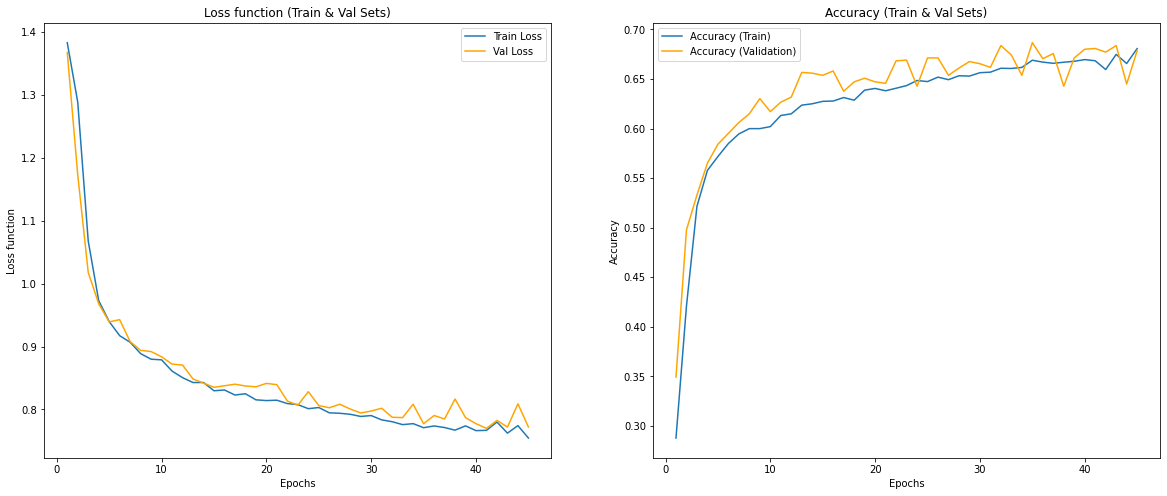

In [64]:
plt.figure(figsize=(20,8))
loss_function = multi_class_history.history['loss']
val_loss_function = multi_class_history.history['val_loss']
epochs = range(1,len(loss_function)+1)

acc = multi_class_history.history['accuracy']
val_acc = multi_class_history.history['val_accuracy']
epochs = range(1,len(acc)+1)

plt.subplot(1, 2, 1)
plt.title('Loss function (Train & Val Sets)')
plt.plot(epochs,loss_function,label='Train Loss')
plt.plot(epochs,val_loss_function,color='orange',label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy (Train & Val Sets)')
plt.plot(epochs,acc,label='Accuracy (Train)')
plt.plot(epochs,val_acc,color='orange',label='Accuracy (Validation)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [65]:
probs = multi_classifier_3.predict(X_test)
truth = np.argmax(y_test, axis=1)

83/83 [==============================] - 0s 1ms/step


In [66]:
predicted = np.argmax(probs, axis=1)

In [67]:
recall = round(recall_score(truth, predicted, average='macro'), 4)
precision = round(precision_score(truth, predicted, average='macro'), 4)
weighted_accuracy = round(balanced_accuracy_score(truth, predicted), 4)
auc = round(roc_auc_score(truth, probs, average='macro', multi_class='ovr'), 4)
df_metrics_multi.loc[len(df_metrics_multi.index)] = ['third_model', recall, precision, weighted_accuracy, auc] 

In [68]:
df_metrics_multi

,model,recall,precision,weighted_accuracy,auc
0,base_model,0.6025,0.5948,0.6025,0.8500
1,second_model,0.6354,0.6503,0.6354,0.8594
2,third_model,0.6826,0.6988,0.6826,0.8872


#### Fourth Model

Добавим Dropout(0.1) после нескольких первых слоёв. В первом слое увеличим количество нейронов до 128:

In [90]:
multi_classifier_4 = Sequential(
    [
        layers.Dense(128, activation = 'relu', input_dim = X_train.shape[1]),
        layers.Dropout(0.1),
        layers.Dense(64, activation = 'sigmoid'),
        layers.Dropout(0.1),
        layers.Dense(32, activation = 'relu'),
        layers.Dense(16, activation = 'sigmoid'),
        layers.Dense(8, activation = 'relu'),
        layers.Dense(4, activation = 'softmax')
    ]
)
multi_classifier_4.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (None, 128)               1536      
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_39 (Dense)            (None, 64)                8256      
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_40 (Dense)            (None, 32)                2080      
                                                                 
 dense_41 (Dense)            (None, 16)                528       
                                                                 
 dense_42 (Dense)            (None, 8)                

Изменим процедуру оптимизации на RMSprop:

In [91]:
multi_classifier_4.compile(loss = 'categorical_crossentropy', optimizer = 'RMSprop', metrics = 'accuracy')

In [92]:
early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 10, mode = 'max', verbose = 1)
checkpoint = ModelCheckpoint('body_weights-{epoch:02d}-{val_accuracy:.3f}.hdf5',
                             monitor = 'val_accuracy', verbose = 1, mode = 'max',
                             save_best_only = True)
callbacks_list = [early_stop,checkpoint]

Увеличим количество эпох в 2 раза:

In [93]:
multi_class_history = multi_classifier_4.fit(X_train, y_train, batch_size = 100, validation_data = (X_valid, y_valid),
                                        callbacks = callbacks_list, epochs = 100)

Epoch 1/100
84/94 [=========================>....] - ETA: 0s - loss: 1.3989 - accuracy: 0.2450
Epoch 1: val_accuracy improved from -inf to 0.24524, saving model to body_weights-01-0.245.hdf5
94/94 [==============================] - 1s 5ms/step - loss: 1.3974 - accuracy: 0.2482 - val_loss: 1.3884 - val_accuracy: 0.2452
Epoch 2/100
78/94 [=======================>......] - ETA: 0s - loss: 1.3857 - accuracy: 0.2587
Epoch 2: val_accuracy improved from 0.24524 to 0.28990, saving model to body_weights-02-0.290.hdf5
94/94 [==============================] - 0s 3ms/step - loss: 1.3853 - accuracy: 0.2597 - val_loss: 1.3868 - val_accuracy: 0.2899
Epoch 3/100
87/94 [==========================>...] - ETA: 0s - loss: 1.3809 - accuracy: 0.2745
Epoch 3: val_accuracy improved from 0.28990 to 0.34261, saving model to body_weights-03-0.343.hdf5
94/94 [==============================] - 0s 4ms/step - loss: 1.3807 - accuracy: 0.2754 - val_loss: 1.3713 - val_accuracy: 0.3426
Epoch 4/100
82/94 [===============

94/94 [==============================] - 0s 3ms/step - loss: 0.8474 - accuracy: 0.6164 - val_loss: 0.8300 - val_accuracy: 0.6545
Epoch 57/100
88/94 [===========================>..] - ETA: 0s - loss: 0.8460 - accuracy: 0.6198
Epoch 57: val_accuracy did not improve from 0.65447
94/94 [==============================] - 0s 3ms/step - loss: 0.8427 - accuracy: 0.6198 - val_loss: 0.8306 - val_accuracy: 0.6523
Epoch 58/100
85/94 [==========================>...] - ETA: 0s - loss: 0.8431 - accuracy: 0.6196
Epoch 58: val_accuracy did not improve from 0.65447
94/94 [==============================] - 0s 3ms/step - loss: 0.8390 - accuracy: 0.6220 - val_loss: 0.8564 - val_accuracy: 0.6201
Epoch 59/100
85/94 [==========================>...] - ETA: 0s - loss: 0.8333 - accuracy: 0.6274
Epoch 59: val_accuracy improved from 0.65447 to 0.65886, saving model to body_weights-59-0.659.hdf5
94/94 [==============================] - 0s 3ms/step - loss: 0.8370 - accuracy: 0.6258 - val_loss: 0.8226 - val_accuracy:

Epoch 85/100
85/94 [==========================>...] - ETA: 0s - loss: 0.7844 - accuracy: 0.6594
Epoch 85: val_accuracy did not improve from 0.69107
94/94 [==============================] - 0s 3ms/step - loss: 0.7823 - accuracy: 0.6609 - val_loss: 0.7924 - val_accuracy: 0.6515
Epoch 86/100
74/94 [======================>.......] - ETA: 0s - loss: 0.7814 - accuracy: 0.6572
Epoch 86: val_accuracy did not improve from 0.69107
94/94 [==============================] - 0s 3ms/step - loss: 0.7780 - accuracy: 0.6594 - val_loss: 0.8144 - val_accuracy: 0.6384
Epoch 87/100
88/94 [===========================>..] - ETA: 0s - loss: 0.7781 - accuracy: 0.6659
Epoch 87: val_accuracy did not improve from 0.69107
94/94 [==============================] - 0s 3ms/step - loss: 0.7763 - accuracy: 0.6675 - val_loss: 0.7816 - val_accuracy: 0.6581
Epoch 88/100
87/94 [==========================>...] - ETA: 0s - loss: 0.7739 - accuracy: 0.6672
Epoch 88: val_accuracy did not improve from 0.69107
94/94 [==============

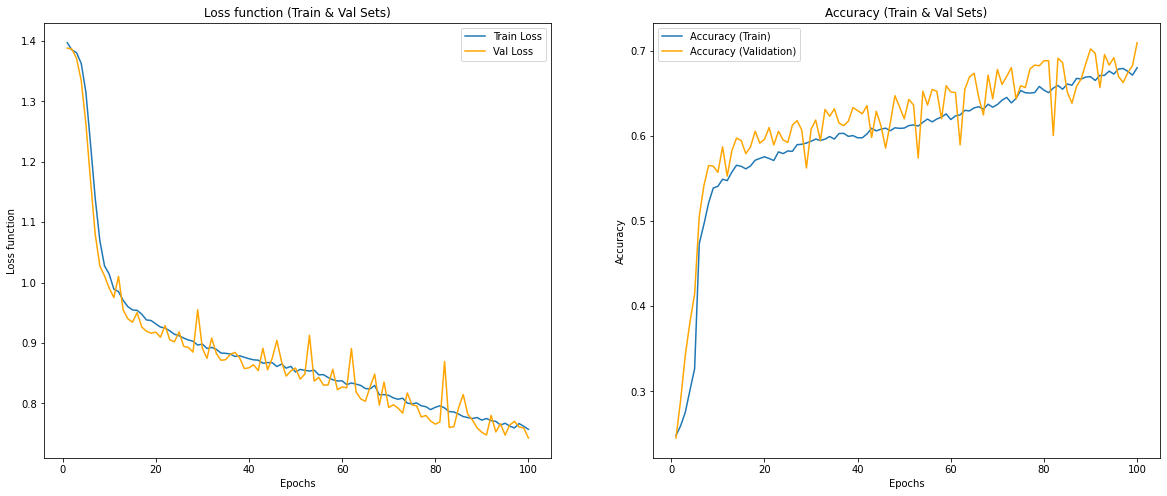

In [94]:
plt.figure(figsize=(20,8))
loss_function = multi_class_history.history['loss']
val_loss_function = multi_class_history.history['val_loss']
epochs = range(1,len(loss_function)+1)

acc = multi_class_history.history['accuracy']
val_acc = multi_class_history.history['val_accuracy']
epochs = range(1,len(acc)+1)

plt.subplot(1, 2, 1)
plt.title('Loss function (Train & Val Sets)')
plt.plot(epochs,loss_function,label='Train Loss')
plt.plot(epochs,val_loss_function,color='orange',label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy (Train & Val Sets)')
plt.plot(epochs,acc,label='Accuracy (Train)')
plt.plot(epochs,val_acc,color='orange',label='Accuracy (Validation)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [95]:
probs = multi_classifier_4.predict(X_test)
truth = np.argmax(y_test, axis=1)

83/83 [==============================] - 0s 1ms/step


In [96]:
predicted = np.argmax(probs, axis=1)

In [98]:
recall = round(recall_score(truth, predicted, average='macro'), 4)
precision = round(precision_score(truth, predicted, average='macro'), 4)
weighted_accuracy = round(balanced_accuracy_score(truth, predicted), 4)
auc = round(roc_auc_score(truth, probs, average='macro', multi_class='ovr'), 4)
df_metrics_multi.loc[len(df_metrics_multi.index)] = ['fourth_model', recall, precision, weighted_accuracy, auc] 

In [99]:
df_metrics_multi

,model,recall,precision,weighted_accuracy,auc
0,base_model,0.6025,0.5948,0.6025,0.8500
1,second_model,0.6354,0.6503,0.6354,0.8594
2,third_model,0.6826,0.6988,0.6826,0.8872
3,fourth_model,0.7032,0.7200,0.7032,0.8967


Анализируя полученные метрики 4-х моделей, можно сделать вывод, что наилучшим многоклассовым классификатором является Fourth Model.

Построим ROC-кривую для каждого класса в данной модели:

In [103]:
probs_4 = multi_classifier_4.predict(X_test)
truth = np.argmax(y_test, axis=1)

83/83 [==============================] - 0s 961us/step


Выведем графики ROC-кривой отдельного для каждого класса:

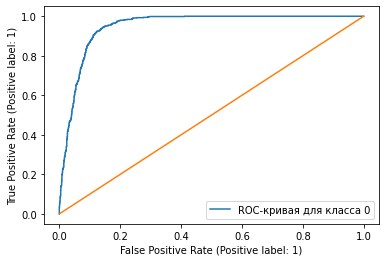

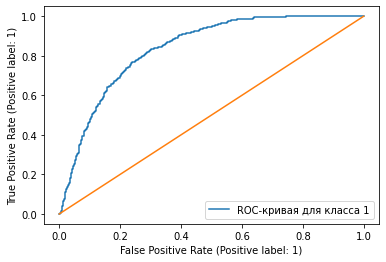

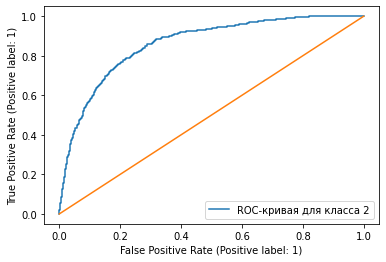

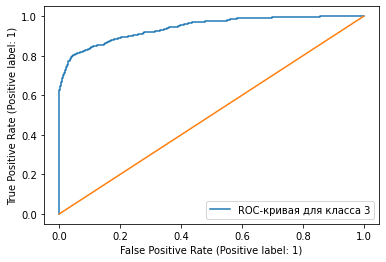

In [170]:
for i in range(0, 4):
    RocCurveDisplay.from_predictions(
        y_test[:, i],
        probs_4[:, i],
        label = f"ROC-кривая для класса {i}"
    )
    x = np.linspace(0, 1, 10)
    y = x
    plt.plot(x,y)
plt.show()

Построим ROC-кривые для каждого класса на одном графике:

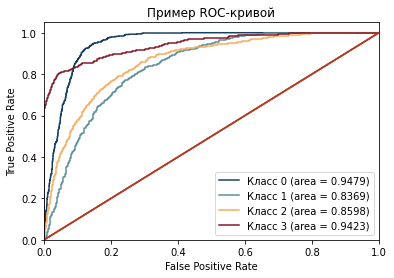

In [181]:
colors = ['#173f61', '#5b8f9a', '#faab5c', '#841826']
for i in range (0, 4):
    fpr, tpr, treshold = roc_curve(y_test[:,i], probs_4[:,i])
    auc = round(roc_auc_score(y_test[:,i], probs_4[:,i]), 4)
    plt.plot(fpr, tpr, label=f"Класс {i} (area = {auc})", color = colors[i])
    plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Пример ROC-кривой')
plt.legend(loc="lower right")
plt.show()

### Вывод

Набор данных 'bodyPerformance.csv' не содержал пропущенных значений, но в нем присутствовал дубликат, который был удален. Значения в столбцах gender и class были закодированы.

Среди четырёх моделей многоклассовых классификаторов лучше всего сработала Fourth Model. В ней увеличено число слоёв и нейронов на каждом слое по сравнению с Base Model, добавлен Dropout(0.1) после двух первых слоёв и используется процедура оптимизации RMSprop.

Оценка качества многоклассовых классификаторов происходила по следующим метрикам: Recall, Precision, Weighted Accuracy и AUC. Эти показатели у Fourth Model выше, чем у остальных моделей.

## Задание №3. Регрессор

### Работа с данными

In [3]:
df = pd.read_csv('DS_2019_public.csv', encoding = "windows-1251")
df.head()

c:\python\lib\site-packages\IPython\core\interactiveshell.py:3185: DtypeWarning: Columns (30,56,96,114) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Climate_Region_Pub,DIVISION,REPORTABLE_DOMAIN,DOLELCOL,TOTALDOLCOL,KWHCOL,BTUELCOL,TOTALBTUCOL,TOTALDOLSPH,TOTALBTUSPH,...,LGT1EE,TOTALBTUWTH,ROOFTYPE,DOLELRFG,TOTALDOLRFG,HEATROOM,WDWATER,UGWARM,DRYRFUEL,KWHRFG
0,5,10,26,16.793,17,181.998,620.979,621,368,38606,...,-2,30110,2,120.893,121,4,0,1,1,1310.220
1,1,1,1,48.901,49,184.459,629.389,629,582,40248,...,2,7933,-2,242.746,243,2,0,1,-2,915.664
2,1,3,7,101.048,101,1063.022,3627.013,3627,425,40196,...,-2,6440,5,158.797,159,7,0,1,5,1670.534
3,1,1,1,0,0,0.000,0.000,0,616,36136,...,2,13884,5,85.138,85,5,0,1,5,346.468
4,1,4,10,45.132,45,274.530,936.677,937,685,74100,...,3,14204,6,151.319,151,6,0,1,5,920.454


In [4]:
df.shape

(10875, 121)

In [5]:
for i in df.columns:
    if df[i].isnull().sum() > 0:
        print(df[i].isnull().sum()/df.shape[0])
    else:
        print('Пропусков нет: ', i)

Пропусков нет:  Climate_Region_Pub
Пропусков нет:  DIVISION
Пропусков нет:  REPORTABLE_DOMAIN
Пропусков нет:  DOLELCOL
Пропусков нет:  TOTALDOLCOL
Пропусков нет:  KWHCOL
Пропусков нет:  BTUELCOL
Пропусков нет:  TOTALBTUCOL
Пропусков нет:  TOTALDOLSPH
Пропусков нет:  TOTALBTUSPH
Пропусков нет:  CELLAR
Пропусков нет:  NWEIGHT
Пропусков нет:  TOTHSQFT
Пропусков нет:  HEATHOME
Пропусков нет:  NUMPC
Пропусков нет:  DOLLAREL
Пропусков нет:  DOLELOTH
Пропусков нет:  CUFEETNGSPH
Пропусков нет:  BTUNGSPH
Пропусков нет:  DOLNGSPH
Пропусков нет:  TEMPHOME
Пропусков нет:  TOTCSQFT
Пропусков нет:  BTUFOSPH
Пропусков нет:  AIRCOND
Пропусков нет:  ELCOOL
Пропусков нет:  GALLONFOSPH
Пропусков нет:  WALLTYPE
Пропусков нет:  TOTALDOLOTH
Пропусков нет:  BTUFO
Пропусков нет:  GALLONFO
Пропусков нет:  DOLFOSPH
Пропусков нет:  DOLLARFO
Пропусков нет:  KWHSPH
Пропусков нет:  BTUELSPH
Пропусков нет:  FOWARM
Пропусков нет:  USEFO
Пропусков нет:  TOTUSQFT
Пропусков нет:  TOTALDOL
Пропусков нет:  NUMTHERM
Пропус

In [6]:
#Пропусков нет
df.isnull().sum()/df.shape[0]

Climate_Region_Pub    0.0
DIVISION              0.0
REPORTABLE_DOMAIN     0.0
DOLELCOL              0.0
TOTALDOLCOL           0.0
                     ... 
HEATROOM              0.0
WDWATER               0.0
UGWARM                0.0
DRYRFUEL              0.0
KWHRFG                0.0
Length: 121, dtype: float64

In [7]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10875 entries, 0 to 10874
Data columns (total 121 columns):
 #    Column              Non-Null Count  Dtype  
---   ------              --------------  -----  
 0    Climate_Region_Pub  10875 non-null  int64  
 1    DIVISION            10875 non-null  int64  
 2    REPORTABLE_DOMAIN   10875 non-null  int64  
 3    DOLELCOL            10875 non-null  object 
 4    TOTALDOLCOL         10875 non-null  int64  
 5    KWHCOL              10875 non-null  float64
 6    BTUELCOL            10875 non-null  float64
 7    TOTALBTUCOL         10875 non-null  int64  
 8    TOTALDOLSPH         10875 non-null  int64  
 9    TOTALBTUSPH         10875 non-null  int64  
 10   CELLAR              10875 non-null  int64  
 11   NWEIGHT             10875 non-null  float64
 12   TOTHSQFT            10875 non-null  int64  
 13   HEATHOME            10875 non-null  int64  
 14   NUMPC               10875 non-null  int64  
 15   DOLLAREL            10875 non-null

Посмотрим, что находится в столбцах типа object:

In [8]:
types = df.dtypes
types = types.loc[types == "object"]

In [9]:
for i in types.index:
    print(i)
    print(df[i].unique())

DOLELCOL
['16.793' '48.901' '101.048' ... '13.005' '97.67' '12.834']
DOLFOSPH
[0.0 1661.0 926.155 847.0 875.0 1106.053 3570.293 779.0 1024.271 2279.0
 1484.04 1520.569 923.0 1094.0 814.629 807.0 712.0 797.359 1089.0 1232.764
 1258.0 1442.609 915.0 1078.608 1898.063 1439.726 1731.774 791.0 1638.045
 952.0 2707.975 1797.946 630.42 1667.645 2381.0 949.0 588.0 932.398
 1390.096 1567.971 1636.683 815.064 1458.0 866.613 1356.052 963.0 778.0
 2207.733 831.0 2131.35 1402.996 971.153 429.135 1672.705 1076.78 1351.0
 2635.615 979.0 704.0 1117.026 1343.804 1043.0 2324.0 2139.038 1468.0
 2374.0 1288.976 753.0 1681.83 831.073 788.0 955.0 1332.046 1980.862 989.0
 1650.223 1759.0 1335.196 761.0 854.0 1315.072 1548.055 1311.0 1376.0
 2404.023 1957.627 3300.179 741.0 865.0 686.0 1710.288 1048.763 132.6
 832.0 1039.0 1069.0 545.77 1020.717 781.0 1771.494 766.0 1685.128
 1123.646 2003.385 3093.119 763.0 730.0 945.0 2222.931 2321.541 1217.755
 916.0 1327.944 1023.79 1559.25 1067.426 1940.981 1044.0 1090.0

Столбцы типа object в основном состоят из числовых значений. Скорее всего, там присутствуют выбросы. Переведем в float все возможные значениях в данных столбцах. Если так сделать нельзя - значение удаляем:

In [10]:
def convert_to_float(x):
    try:
        return float(x)
    except:
        return np.nan

In [11]:
for i in types.index:
    df[i] = df[i].apply(lambda x: convert_to_float(x))
    print(i)
    print(df[i].isnull().sum())

DOLELCOL
70
DOLFOSPH
1
DOLELSPH
4
DOLNGWTH
2
CUFEETNGOTH
12
KWHOTH
1
CUFEETNGWTH
3
DOLELRFG
1


Удаляем строки с пропущенными значениями:

In [12]:
df.dropna(inplace=True)
df.shape

(10785, 121)

In [13]:
#Дубликатов нет
df = df.drop_duplicates()
df.shape

(10785, 121)

In [14]:
df.describe()

,Climate_Region_Pub,DIVISION,REPORTABLE_DOMAIN,DOLELCOL,TOTALDOLCOL,KWHCOL,BTUELCOL,TOTALBTUCOL,TOTALDOLSPH,TOTALBTUSPH,...,LGT1EE,TOTALBTUWTH,ROOFTYPE,DOLELRFG,TOTALDOLRFG,HEATROOM,WDWATER,UGWARM,DRYRFUEL,KWHRFG
count,10785.000000,10785.000000,10785.000000,10785.000000,10785.000000,10785.000000,10785.000000,10785.000000,10785.000000,10785.000000,...,10785.000000,10785.000000,10785.000000,10785.000000,10785.000000,10785.000000,10785.000000,10785.000000,10785.000000,10785.000000
mean,2.608067,5.376263,14.798146,203.750405,203.749652,1693.624306,5778.645776,5778.642281,561.049235,36878.418730,...,0.818173,16344.560779,3.673621,154.725129,154.728234,5.349096,0.000834,0.500788,2.984979,1246.633642
std,1.347541,2.859324,8.199397,311.318456,311.321580,2485.590453,8480.833423,8480.830656,505.514181,35826.928857,...,2.350035,13755.839203,2.773690,107.181736,107.184538,2.639938,0.028877,0.500023,2.840688,778.412482
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-9.000000,0.000000,-2.000000,0.000000,0.000000,-2.000000,0.000000,0.000000,-2.000000,0.000000
25%,1.000000,3.000000,8.000000,19.413000,19.000000,150.993000,515.182000,515.000000,222.000000,8713.000000,...,0.000000,7718.000000,2.000000,86.393000,86.000000,4.000000,0.000000,0.000000,1.000000,725.791000
50%,3.000000,5.000000,16.000000,90.775000,91.000000,763.090000,2603.690000,2604.000000,430.000000,27209.000000,...,0.000000,12778.000000,5.000000,127.090000,127.000000,5.000000,0.000000,1.000000,5.000000,1049.151000
75%,4.000000,7.000000,21.000000,264.527000,265.000000,2303.045000,7858.013000,7858.000000,762.000000,55719.000000,...,2.000000,21193.000000,5.000000,192.992000,193.000000,7.000000,0.000000,1.000000,5.000000,1561.557000
max,5.000000,10.000000,27.000000,7729.265000,7729.000000,60995.431000,208116.552000,208117.000000,9264.000000,548711.000000,...,40.000000,284130.000000,8.000000,2490.046000,2490.000000,23.000000,1.000000,1.000000,5.000000,11069.027000


В некоторых столбцах присутствуют выбросы в виде отрицательных значений. Удалим такие значения:

In [15]:
for i in df.columns:
    df.loc[df[i]<0, i] = np.nan
    if (df[i].isnull().sum()/df.shape[0])>0:
        print(i)
        print(df[i].isnull().sum()/df.shape[0])

CELLAR
0.20407974038015764
TEMPHOME
0.03801576263328697
NUMTHERM
0.15159944367176634
CONCRETE
0.20407974038015764
BEDROOMS
0.0181733889661567
FUELHEAT
0.03801576263328697
COOLTYPE
0.17923041261010664
DOOR1SUM
9.27213722763097e-05
EQUIPM
0.03801576263328697
STORIES
0.23532684283727398
FUELH2O
0.0028743625405656
TEMPGONE
0.03801576263328697
LGT1EE
0.16430227167362077
ROOFTYPE
0.15957348168752897
HEATROOM
0.03801576263328697
DRYRFUEL
0.19499304589707928


Появились столбцы с пропущенными значениями. Удалим столбцы с процентом NaN больше 5%. В остальных удалим строки с пропущенными значениям:

In [16]:
for i in df.columns:
    if (df[i].isnull().sum()/df.shape[0])>=0.05:
        df = df.drop(i, axis=1)

In [17]:
df.shape

(10785, 113)

In [18]:
df.dropna(inplace=True)

In [19]:
#Пропущенных значений нет
df.isnull().sum().sum()

0

In [20]:
df.head()

,Climate_Region_Pub,DIVISION,REPORTABLE_DOMAIN,DOLELCOL,TOTALDOLCOL,KWHCOL,BTUELCOL,TOTALBTUCOL,TOTALDOLSPH,TOTALBTUSPH,...,UGWATER,SDESCENT,TEMPGONE,TOTALBTUWTH,DOLELRFG,TOTALDOLRFG,HEATROOM,WDWATER,UGWARM,KWHRFG
0,5.0,10.0,26.0,16.793,17.0,181.998,620.979,621.0,368.0,38606.0,...,1.0,0.0,70.0,30110.0,120.893,121.0,4.0,0.0,1.0,1310.220
1,1.0,1.0,1.0,48.901,49.0,184.459,629.389,629.0,582.0,40248.0,...,1.0,0.0,60.0,7933.0,242.746,243.0,2.0,0.0,1.0,915.664
2,1.0,3.0,7.0,101.048,101.0,1063.022,3627.013,3627.0,425.0,40196.0,...,0.0,0.0,55.0,6440.0,158.797,159.0,7.0,0.0,1.0,1670.534
3,1.0,1.0,1.0,0.000,0.0,0.000,0.000,0.0,616.0,36136.0,...,1.0,0.0,70.0,13884.0,85.138,85.0,5.0,0.0,1.0,346.468
4,1.0,4.0,10.0,45.132,45.0,274.530,936.677,937.0,685.0,74100.0,...,1.0,0.0,66.0,14204.0,151.319,151.0,6.0,0.0,1.0,920.454


In [21]:
X = df.drop(['TOTALDOL'],axis=1)
y = df['TOTALDOL']

In [22]:
min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)

Разделим датасет на три части: тренировочную (70%), тестовую (20%) и валидационную (10%).

In [23]:
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.7, random_state=77)

X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.66, random_state=77)

### Создание моделей
#### Base Model

Создадим базовую модель нейронной сети, состоящую из 2 слоёв:
1. 16 нейронов, функция активации - ReLU
2. 1 нейрон

In [63]:
regressor = Sequential(
    [
        layers.Dense(16, activation = 'relu', input_dim = X_train.shape[1]),
        layers.Dense(1)
    ]
)
regressor.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 16)                1808      
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1825 (7.13 KB)
Trainable params: 1825 (7.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [64]:
regressor.compile(loss = 'mean_squared_error', optimizer = 'adam')

Будем отслеживать уменьшение функции потерь:

In [65]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', verbose =1)
checkpoint = ModelCheckpoint('household-{epoch:02d}-{val_loss:.3f}.hdf5',
                             monitor = 'val_loss', verbose = 1, mode = 'min',
                             save_best_only = True)
callbacks_list = [early_stop,checkpoint]

Возьмем количество эпох в 2 раза больше, чем мы использовали в классификаторах:

In [66]:
regressor_history = regressor.fit(X_train, y_train, batch_size = 10, validation_data = (X_valid, y_valid),
                                        callbacks = callbacks_list, epochs = 200)

Epoch 1/200
701/714 [============================>.] - ETA: 0s - loss: 5667780.0000
Epoch 1: val_loss improved from inf to 5189722.50000, saving model to household-01-5189722.500.hdf5
714/714 [==============================] - 1s 1ms/step - loss: 5661777.5000 - val_loss: 5189722.5000
Epoch 2/200
120/714 [====>.........................] - ETA: 0s - loss: 4971581.0000

c:\python\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


704/714 [============================>.] - ETA: 0s - loss: 4755553.5000
Epoch 2: val_loss improved from 5189722.50000 to 4020010.75000, saving model to household-02-4020010.750.hdf5
714/714 [==============================] - 1s 1ms/step - loss: 4741457.5000 - val_loss: 4020010.7500
Epoch 3/200
694/714 [============================>.] - ETA: 0s - loss: 3498574.0000
Epoch 3: val_loss improved from 4020010.75000 to 2739178.50000, saving model to household-03-2739178.500.hdf5
714/714 [==============================] - 1s 1ms/step - loss: 3471441.5000 - val_loss: 2739178.5000
Epoch 4/200
695/714 [============================>.] - ETA: 0s - loss: 2347139.7500
Epoch 4: val_loss improved from 2739178.50000 to 1772570.87500, saving model to household-04-1772570.875.hdf5
714/714 [==============================] - 1s 1ms/step - loss: 2327667.2500 - val_loss: 1772570.8750
Epoch 5/200
688/714 [===========================>..] - ETA: 0s - loss: 1596166.8750
Epoch 5: val_loss improved from 1772570.875

677/714 [===========================>..] - ETA: 0s - loss: 170532.2656
Epoch 58: val_loss improved from 146547.07812 to 142545.95312, saving model to household-58-142545.953.hdf5
714/714 [==============================] - 1s 2ms/step - loss: 168058.7031 - val_loss: 142545.9531
Epoch 59/200
705/714 [============================>.] - ETA: 0s - loss: 164080.4062
Epoch 59: val_loss improved from 142545.95312 to 138474.01562, saving model to household-59-138474.016.hdf5
714/714 [==============================] - 1s 2ms/step - loss: 163423.1406 - val_loss: 138474.0156
Epoch 60/200
693/714 [============================>.] - ETA: 0s - loss: 159577.9688
Epoch 60: val_loss improved from 138474.01562 to 135195.21875, saving model to household-60-135195.219.hdf5
714/714 [==============================] - 1s 2ms/step - loss: 158895.8281 - val_loss: 135195.2188
Epoch 61/200
710/714 [============================>.] - ETA: 0s - loss: 155220.0469
Epoch 61: val_loss improved from 135195.21875 to 131219.

714/714 [==============================] - 1s 2ms/step - loss: 80468.7188 - val_loss: 69253.3672
Epoch 87/200
688/714 [===========================>..] - ETA: 0s - loss: 76723.4453
Epoch 87: val_loss improved from 69253.36719 to 67432.67969, saving model to household-87-67432.680.hdf5
714/714 [==============================] - 1s 2ms/step - loss: 78609.2578 - val_loss: 67432.6797
Epoch 88/200
695/714 [============================>.] - ETA: 0s - loss: 77390.6016
Epoch 88: val_loss improved from 67432.67969 to 66091.64062, saving model to household-88-66091.641.hdf5
714/714 [==============================] - 1s 2ms/step - loss: 76727.6016 - val_loss: 66091.6406
Epoch 89/200
695/714 [============================>.] - ETA: 0s - loss: 75456.8047
Epoch 89: val_loss improved from 66091.64062 to 64844.18359, saving model to household-89-64844.184.hdf5
714/714 [==============================] - 1s 2ms/step - loss: 75001.0312 - val_loss: 64844.1836
Epoch 90/200
706/714 [==========================

714/714 [==============================] - 1s 2ms/step - loss: 23683.2207 - val_loss: 21844.3008
Epoch 144/200
699/714 [============================>.] - ETA: 0s - loss: 23284.7930
Epoch 144: val_loss improved from 21844.30078 to 21721.71484, saving model to household-144-21721.715.hdf5
714/714 [==============================] - 1s 2ms/step - loss: 23212.8008 - val_loss: 21721.7148
Epoch 145/200
708/714 [============================>.] - ETA: 0s - loss: 22712.0137
Epoch 145: val_loss improved from 21721.71484 to 21077.55273, saving model to household-145-21077.553.hdf5
714/714 [==============================] - 1s 2ms/step - loss: 22719.4883 - val_loss: 21077.5527
Epoch 146/200
695/714 [============================>.] - ETA: 0s - loss: 22414.0566
Epoch 146: val_loss improved from 21077.55273 to 20750.28125, saving model to household-146-20750.281.hdf5
714/714 [==============================] - 1s 2ms/step - loss: 22245.7520 - val_loss: 20750.2812
Epoch 147/200
686/714 [================

714/714 [==============================] - 1s 2ms/step - loss: 13105.3672 - val_loss: 13300.3164
Epoch 173/200
687/714 [===========================>..] - ETA: 0s - loss: 12882.1357
Epoch 173: val_loss improved from 13300.31641 to 13066.18848, saving model to household-173-13066.188.hdf5
714/714 [==============================] - 1s 2ms/step - loss: 12831.9102 - val_loss: 13066.1885
Epoch 174/200
700/714 [============================>.] - ETA: 0s - loss: 12652.7988
Epoch 174: val_loss improved from 13066.18848 to 12928.98926, saving model to household-174-12928.989.hdf5
714/714 [==============================] - 1s 2ms/step - loss: 12565.8281 - val_loss: 12928.9893
Epoch 175/200
713/714 [============================>.] - ETA: 0s - loss: 12331.9717
Epoch 175: val_loss improved from 12928.98926 to 12751.33203, saving model to household-175-12751.332.hdf5
714/714 [==============================] - 1s 2ms/step - loss: 12325.7100 - val_loss: 12751.3320
Epoch 176/200
696/714 [================

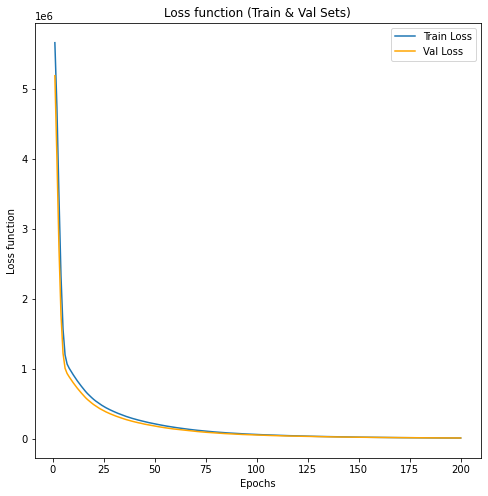

In [67]:
plt.figure(figsize=(8,8))
loss_function = regressor_history.history['loss']
val_loss_function = regressor_history.history['val_loss']
epochs = range(1,len(loss_function)+1)

plt.title('Loss function (Train & Val Sets)')
plt.plot(epochs,loss_function,label='Train Loss')
plt.plot(epochs,val_loss_function,color='orange',label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.legend()

In [98]:
probs = regressor.predict(X_test)
truth = y_test

64/64 [==============================] - 0s 933us/step


In [99]:
df_metrics_regress = pd.DataFrame(columns=['model', 'mse', 'mae', 'r2'])
mse = round(mean_squared_error(probs, truth), 3)
mae = round(mean_absolute_error(probs, truth), 3)
r2 = round(r2_score(probs, truth), 5)
df_metrics_regress.loc[len(df_metrics_regress.index)] = ['base_model', mse, mae, r2] 

In [100]:
df_metrics_regress

,model,mse,mae,r2
0,base_model,6439.512,51.051,0.99453


#### Second Model

Во второй модели увеличим количество слоёв, не увиличивая число нейронов и чередуя функции активации:
1. 16 нейронов, функция активации - ReLU
2. 16 нейронов, функция активации - Sigmoid
3. 16 нейронов, функция активации - SeLU
4. 16 нейронов, функция активации - Sigmoid
5. 16 нейронов, функция активации - ReLU
6. 1 нейрон

In [72]:
regressor_2 = Sequential(
    [
        layers.Dense(16, activation = 'relu', input_dim = X_train.shape[1]),
        layers.Dense(16, activation = 'sigmoid'),
        layers.Dense(16, activation = 'selu'),
        layers.Dense(16, activation = 'sigmoid'),
        layers.Dense(16, activation = 'relu'),
        layers.Dense(1)
    ]
)
regressor_2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 16)                1808      
                                                                 
 dense_11 (Dense)            (None, 16)                272       
                                                                 
 dense_12 (Dense)            (None, 16)                272       
                                                                 
 dense_13 (Dense)            (None, 16)                272       
                                                                 
 dense_14 (Dense)            (None, 16)                272       
                                                                 
 dense_15 (Dense)            (None, 1)                 17        
                                                                 
Total params: 2913 (11.38 KB)
Trainable params: 2913 (

In [73]:
regressor_2.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [74]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', verbose =1)
checkpoint = ModelCheckpoint('household_2-{epoch:02d}-{val_loss:.3f}.hdf5',
                             monitor = 'val_loss', verbose = 1, mode = 'min',
                             save_best_only = True)
callbacks_list = [early_stop,checkpoint]

In [75]:
regressor_history = regressor_2.fit(X_train, y_train, batch_size = 10, validation_data = (X_valid, y_valid),
                                        callbacks = callbacks_list, epochs = 200)

Epoch 1/200
694/714 [============================>.] - ETA: 0s - loss: 5730585.5000
Epoch 1: val_loss improved from inf to 5434767.50000, saving model to household_2-01-5434767.500.hdf5
714/714 [==============================] - 3s 2ms/step - loss: 5755953.0000 - val_loss: 5434767.5000
Epoch 2/200
 93/714 [==>...........................] - ETA: 1s - loss: 5600228.0000

c:\python\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


711/714 [============================>.] - ETA: 0s - loss: 5147722.5000
Epoch 2: val_loss improved from 5434767.50000 to 4588698.50000, saving model to household_2-02-4588698.500.hdf5
714/714 [==============================] - 1s 2ms/step - loss: 5147585.5000 - val_loss: 4588698.5000
Epoch 3/200
690/714 [===========================>..] - ETA: 0s - loss: 4243853.0000
Epoch 3: val_loss improved from 4588698.50000 to 3591250.75000, saving model to household_2-03-3591250.750.hdf5
714/714 [==============================] - 1s 2ms/step - loss: 4207330.0000 - val_loss: 3591250.7500
Epoch 4/200
712/714 [============================>.] - ETA: 0s - loss: 3237738.2500
Epoch 4: val_loss improved from 3591250.75000 to 2668815.75000, saving model to household_2-04-2668815.750.hdf5
714/714 [==============================] - 1s 2ms/step - loss: 3233195.0000 - val_loss: 2668815.7500
Epoch 5/200
713/714 [============================>.] - ETA: 0s - loss: 2419496.7500
Epoch 5: val_loss improved from 26688

714/714 [==============================] - 1s 2ms/step - loss: 91251.4297 - val_loss: 284.0253
Epoch 61/200
688/714 [===========================>..] - ETA: 0s - loss: 90418.7969
Epoch 61: val_loss did not improve from 284.02527
714/714 [==============================] - 1s 2ms/step - loss: 89562.7578 - val_loss: 296.7031
Epoch 62/200
711/714 [============================>.] - ETA: 0s - loss: 89144.6562
Epoch 62: val_loss did not improve from 284.02527
714/714 [==============================] - 1s 2ms/step - loss: 88835.2266 - val_loss: 915.7698
Epoch 63/200
686/714 [===========================>..] - ETA: 0s - loss: 92084.6016
Epoch 63: val_loss did not improve from 284.02527
714/714 [==============================] - 1s 2ms/step - loss: 88551.5000 - val_loss: 720.6712
Epoch 64/200
693/714 [============================>.] - ETA: 0s - loss: 89444.2109
Epoch 64: val_loss improved from 284.02527 to 230.61179, saving model to household_2-64-230.612.hdf5
714/714 [============================

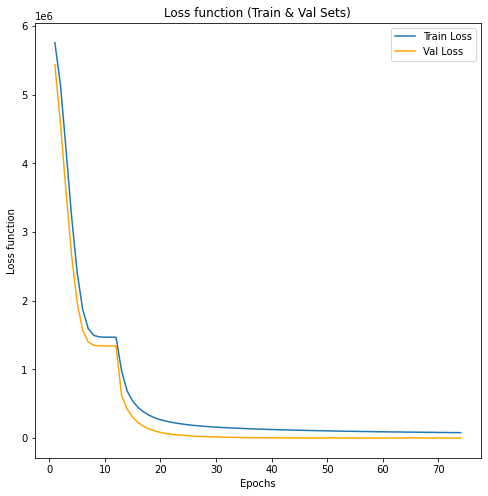

In [76]:
plt.figure(figsize=(8,8))
loss_function = regressor_history.history['loss']
val_loss_function = regressor_history.history['val_loss']
epochs = range(1,len(loss_function)+1)

plt.title('Loss function (Train & Val Sets)')
plt.plot(epochs,loss_function,label='Train Loss')
plt.plot(epochs,val_loss_function,color='orange',label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.legend()

In [101]:
probs = regressor_2.predict(X_test)
truth = y_test

64/64 [==============================] - 0s 1ms/step


In [102]:
mse = round(mean_squared_error(probs, truth), 3)
mae = round(mean_absolute_error(probs, truth), 3)
r2 = round(r2_score(probs, truth), 5)
df_metrics_regress.loc[len(df_metrics_regress.index)] = ['second_model', mse, mae, r2] 

In [103]:
df_metrics_regress

,model,mse,mae,r2
0,base_model,6439.512,51.051,0.99453
1,second_model,1658.268,28.584,0.99859


#### Third Model

Увеличим количество нейронов на каждом слое, кроме двух последних:
1. 64 нейрона, функция активации - ReLU
2. 64 нейрона, функция активации - Sigmoid
3. 32 нейрона, функция активации - SeLU
4. 32 нейронов, функция активации - Sigmoid
5. 16 нейронов, функция активации - ReLU
6. 1 нейрон

In [86]:
regressor_3 = Sequential(
    [
        layers.Dense(64, activation = 'relu', input_dim = X_train.shape[1]),
        layers.Dense(64, activation = 'sigmoid'),
        layers.Dense(32, activation = 'selu'),
        layers.Dense(32, activation = 'sigmoid'),
        layers.Dense(16, activation = 'relu'),
        layers.Dense(1)
    ]
)
regressor_3.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 64)                7232      
                                                                 
 dense_23 (Dense)            (None, 64)                4160      
                                                                 
 dense_24 (Dense)            (None, 32)                2080      
                                                                 
 dense_25 (Dense)            (None, 32)                1056      
                                                                 
 dense_26 (Dense)            (None, 16)                528       
                                                                 
 dense_27 (Dense)            (None, 1)                 17        
                                                                 
Total params: 15073 (58.88 KB)
Trainable params: 15073

In [91]:
regressor_3.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [92]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', verbose = 1)
checkpoint = ModelCheckpoint('household_3-{epoch:02d}-{val_loss:.3f}.hdf5',
                             monitor = 'val_loss', verbose = 1, mode = 'min',
                             save_best_only = True)
callbacks_list = [early_stop,checkpoint]

Увеличим число объектов в одном батче в 10 раз и уменьшим количество эпох в 1,25 раз:

In [93]:
regressor_history = regressor_3.fit(X_train, y_train, batch_size = 100, validation_data = (X_valid, y_valid),
                                        callbacks = callbacks_list, epochs = 160)

Epoch 1/160
71/72 [============================>.] - ETA: 0s - loss: 1444152.0000
Epoch 1: val_loss improved from inf to 1200593.50000, saving model to household_3-01-1200593.500.hdf5
72/72 [==============================] - 1s 3ms/step - loss: 1447680.5000 - val_loss: 1200593.5000
Epoch 2/160
70/72 [============================>.] - ETA: 0s - loss: 1130851.0000
Epoch 2: val_loss improved from 1200593.50000 to 874414.87500, saving model to household_3-02-874414.875.hdf5
72/72 [==============================] - 0s 2ms/step - loss: 1135030.0000 - val_loss: 874414.8750
Epoch 3/160
36/72 [==============>...............] - ETA: 0s - loss: 1093741.8750
Epoch 3: val_loss improved from 874414.87500 to 801919.31250, saving model to household_3-03-801919.312.hdf5
72/72 [==============================] - 0s 2ms/step - loss: 995596.7500 - val_loss: 801919.3125
Epoch 4/160
68/72 [===========================>..] - ETA: 0s - loss: 931836.7500
Epoch 4: val_loss improved from 801919.31250 to 744184.937

72/72 [==============================] - 0s 2ms/step - loss: 396510.6562 - val_loss: 208673.2344
Epoch 30/160
37/72 [==============>...............] - ETA: 0s - loss: 482732.0625
Epoch 30: val_loss improved from 208673.23438 to 200004.82812, saving model to household_3-30-200004.828.hdf5
72/72 [==============================] - 0s 2ms/step - loss: 387194.3125 - val_loss: 200004.8281
Epoch 31/160
37/72 [==============>...............] - ETA: 0s - loss: 243997.8906 
Epoch 31: val_loss improved from 200004.82812 to 191836.37500, saving model to household_3-31-191836.375.hdf5
72/72 [==============================] - 0s 2ms/step - loss: 378206.8438 - val_loss: 191836.3750
Epoch 32/160
62/72 [========================>.....] - ETA: 0s - loss: 262288.0312
Epoch 32: val_loss improved from 191836.37500 to 182928.89062, saving model to household_3-32-182928.891.hdf5
72/72 [==============================] - 0s 2ms/step - loss: 369698.0000 - val_loss: 182928.8906
Epoch 33/160
64/72 [===============

Epoch 87/160
64/72 [=========================>....] - ETA: 0s - loss: 179608.8125
Epoch 87: val_loss improved from 20675.44141 to 19460.49609, saving model to household_3-87-19460.496.hdf5
72/72 [==============================] - 0s 2ms/step - loss: 165859.6875 - val_loss: 19460.4961
Epoch 88/160
64/72 [=========================>....] - ETA: 0s - loss: 170343.1250
Epoch 88: val_loss improved from 19460.49609 to 18597.90820, saving model to household_3-88-18597.908.hdf5
72/72 [==============================] - 0s 2ms/step - loss: 164307.4531 - val_loss: 18597.9082
Epoch 89/160
65/72 [==========================>...] - ETA: 0s - loss: 175340.8594
Epoch 89: val_loss improved from 18597.90820 to 17845.38672, saving model to household_3-89-17845.387.hdf5
72/72 [==============================] - 0s 2ms/step - loss: 162763.2812 - val_loss: 17845.3867
Epoch 90/160
62/72 [========================>.....] - ETA: 0s - loss: 167677.7969
Epoch 90: val_loss improved from 17845.38672 to 17335.26367, sa

72/72 [==============================] - 0s 3ms/step - loss: 110363.8359 - val_loss: 1060.9735
Epoch 147/160
60/72 [========================>.....] - ETA: 0s - loss: 130588.3594
Epoch 147: val_loss improved from 1060.97351 to 1033.36841, saving model to household_3-147-1033.368.hdf5
72/72 [==============================] - 0s 2ms/step - loss: 109846.9531 - val_loss: 1033.3684
Epoch 148/160
69/72 [===========================>..] - ETA: 0s - loss: 112552.5391
Epoch 148: val_loss did not improve from 1033.36841
72/72 [==============================] - 0s 2ms/step - loss: 109151.0000 - val_loss: 1041.0079
Epoch 149/160
68/72 [===========================>..] - ETA: 0s - loss: 113911.2969
Epoch 149: val_loss did not improve from 1033.36841
72/72 [==============================] - 0s 2ms/step - loss: 108903.5469 - val_loss: 1221.6306
Epoch 150/160
66/72 [==========================>...] - ETA: 0s - loss: 115949.9531
Epoch 150: val_loss did not improve from 1033.36841
72/72 [===================

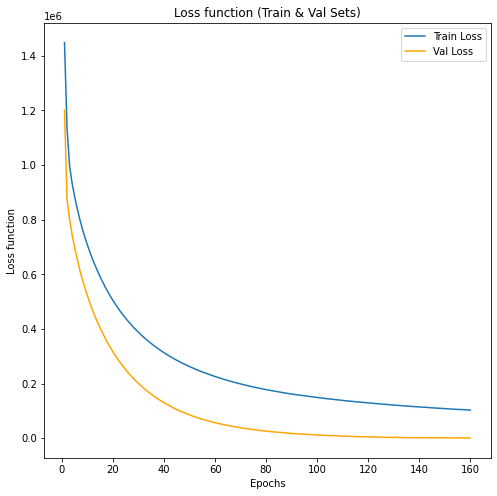

In [94]:
plt.figure(figsize=(8,8))
loss_function = regressor_history.history['loss']
val_loss_function = regressor_history.history['val_loss']
epochs = range(1,len(loss_function)+1)

plt.title('Loss function (Train & Val Sets)')
plt.plot(epochs,loss_function,label='Train Loss')
plt.plot(epochs,val_loss_function,color='orange',label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.legend()

In [104]:
probs = regressor_3.predict(X_test)
truth = y_test

64/64 [==============================] - 0s 1ms/step


In [105]:
mse = round(mean_squared_error(probs, truth), 3)
mae = round(mean_absolute_error(probs, truth), 3)
r2 = round(r2_score(probs, truth), 5)
df_metrics_regress.loc[len(df_metrics_regress.index)] = ['third_model', mse, mae, r2] 

In [106]:
df_metrics_regress

,model,mse,mae,r2
0,base_model,6439.512,51.051,0.99453
1,second_model,1658.268,28.584,0.99859
2,third_model,1169.393,6.070,0.99900


#### Fourth Model

Добавим Dropout(0.1) после нескольких первых слоёв. В первом слое увеличим количество нейронов до 128:

In [150]:
regressor_4 = Sequential(
    [
        layers.Dense(128, activation = 'relu', input_dim = X_train.shape[1]),
        layers.Dropout(0.1),
        layers.Dense(64, activation = 'sigmoid'),
        layers.Dropout(0.1),
        layers.Dense(32, activation = 'selu'),
        layers.Dense(32, activation = 'sigmoid'),
        layers.Dense(16, activation = 'relu'),
        layers.Dense(1)
    ]
)
regressor_4.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_58 (Dense)            (None, 128)               14464     
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_59 (Dense)            (None, 64)                8256      
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_60 (Dense)            (None, 32)                2080      
                                                                 
 dense_61 (Dense)            (None, 32)                1056      
                                                                 
 dense_62 (Dense)            (None, 16)              

Изменим процедуру оптимизации на RMSprop:

In [151]:
regressor_4.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [152]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', verbose = 1)
checkpoint = ModelCheckpoint('household_4-{epoch:02d}-{val_loss:.3f}.hdf5',
                             monitor = 'val_loss', verbose = 1, mode = 'min',
                             save_best_only = True)
callbacks_list = [early_stop,checkpoint]

Увеличим количество эпох в 1,25 раз:

In [153]:
regressor_history = regressor_4.fit(X_train, y_train, batch_size = 100, validation_data = (X_valid, y_valid),
                                        callbacks = callbacks_list, epochs = 200)

Epoch 1/200
65/72 [==========================>...] - ETA: 0s - loss: 5671003.5000
Epoch 1: val_loss improved from inf to 5742278.50000, saving model to household_4-01-5742278.500.hdf5
72/72 [==============================] - 1s 4ms/step - loss: 5865688.0000 - val_loss: 5742278.5000
Epoch 2/200
65/72 [==========================>...] - ETA: 0s - loss: 5829101.0000
Epoch 2: val_loss improved from 5742278.50000 to 5704124.00000, saving model to household_4-02-5704124.000.hdf5
72/72 [==============================] - 0s 3ms/step - loss: 5834629.5000 - val_loss: 5704124.0000
Epoch 3/200
71/72 [============================>.] - ETA: 0s - loss: 5791829.5000
Epoch 3: val_loss improved from 5704124.00000 to 5648713.50000, saving model to household_4-03-5648713.500.hdf5
72/72 [==============================] - 0s 4ms/step - loss: 5787869.5000 - val_loss: 5648713.5000
Epoch 4/200
61/72 [========================>.....] - ETA: 0s - loss: 5712035.0000
Epoch 4: val_loss improved from 5648713.50000 to 

Epoch 29/200
62/72 [========================>.....] - ETA: 0s - loss: 1842327.6250
Epoch 29: val_loss improved from 1756882.50000 to 1674649.12500, saving model to household_4-29-1674649.125.hdf5
72/72 [==============================] - 0s 4ms/step - loss: 1837431.1250 - val_loss: 1674649.1250
Epoch 30/200
70/72 [============================>.] - ETA: 0s - loss: 1769290.5000
Epoch 30: val_loss improved from 1674649.12500 to 1604816.87500, saving model to household_4-30-1604816.875.hdf5
72/72 [==============================] - 0s 4ms/step - loss: 1761771.7500 - val_loss: 1604816.8750
Epoch 31/200
72/72 [==============================] - ETA: 0s - loss: 1698394.7500
Epoch 31: val_loss improved from 1604816.87500 to 1546217.75000, saving model to household_4-31-1546217.750.hdf5
72/72 [==============================] - 0s 4ms/step - loss: 1698394.7500 - val_loss: 1546217.7500
Epoch 32/200
56/72 [======================>.......] - ETA: 0s - loss: 1652597.0000
Epoch 32: val_loss improved from

72/72 [==============================] - 0s 5ms/step - loss: 1467920.2500 - val_loss: 1341236.0000
Epoch 58/200
64/72 [=========================>....] - ETA: 0s - loss: 1494591.2500
Epoch 58: val_loss improved from 1341236.00000 to 1341204.87500, saving model to household_4-58-1341204.875.hdf5
72/72 [==============================] - 0s 5ms/step - loss: 1467947.8750 - val_loss: 1341204.8750
Epoch 59/200
65/72 [==========================>...] - ETA: 0s - loss: 1480149.5000
Epoch 59: val_loss did not improve from 1341204.87500
72/72 [==============================] - 0s 5ms/step - loss: 1467987.0000 - val_loss: 1341207.0000
Epoch 60/200
67/72 [==========================>...] - ETA: 0s - loss: 1465371.8750
Epoch 60: val_loss improved from 1341204.87500 to 1341201.25000, saving model to household_4-60-1341201.250.hdf5
72/72 [==============================] - 0s 5ms/step - loss: 1467955.2500 - val_loss: 1341201.2500
Epoch 61/200
62/72 [========================>.....] - ETA: 0s - loss: 14849

Epoch 88/200
59/72 [=======================>......] - ETA: 0s - loss: 387852.5312
Epoch 88: val_loss improved from 157483.09375 to 145685.78125, saving model to household_4-88-145685.781.hdf5
72/72 [==============================] - 0s 5ms/step - loss: 338478.2500 - val_loss: 145685.7812
Epoch 89/200
61/72 [========================>.....] - ETA: 0s - loss: 352806.0938
Epoch 89: val_loss improved from 145685.78125 to 135860.53125, saving model to household_4-89-135860.531.hdf5
72/72 [==============================] - 0s 4ms/step - loss: 327246.4375 - val_loss: 135860.5312
Epoch 90/200
71/72 [============================>.] - ETA: 0s - loss: 206015.7344
Epoch 90: val_loss improved from 135860.53125 to 127250.96875, saving model to household_4-90-127250.969.hdf5
72/72 [==============================] - 0s 5ms/step - loss: 316921.9688 - val_loss: 127250.9688
Epoch 91/200
59/72 [=======================>......] - ETA: 0s - loss: 209326.6719
Epoch 91: val_loss improved from 127250.96875 to 11

72/72 [==============================] - 0s 4ms/step - loss: 185068.7188 - val_loss: 27134.5117
Epoch 117/200
72/72 [==============================] - ETA: 0s - loss: 182159.2500
Epoch 117: val_loss improved from 27134.51172 to 27027.53320, saving model to household_4-117-27027.533.hdf5
72/72 [==============================] - 0s 4ms/step - loss: 182159.2500 - val_loss: 27027.5332
Epoch 118/200
71/72 [============================>.] - ETA: 0s - loss: 180742.2812
Epoch 118: val_loss improved from 27027.53320 to 24124.35547, saving model to household_4-118-24124.355.hdf5
72/72 [==============================] - 0s 4ms/step - loss: 179876.3125 - val_loss: 24124.3555
Epoch 119/200
69/72 [===========================>..] - ETA: 0s - loss: 183206.5312
Epoch 119: val_loss improved from 24124.35547 to 23857.50391, saving model to household_4-119-23857.504.hdf5
72/72 [==============================] - 0s 4ms/step - loss: 177471.9375 - val_loss: 23857.5039
Epoch 120/200
65/72 [===================

Epoch 146/200
72/72 [==============================] - ETA: 0s - loss: 130779.7422
Epoch 146: val_loss improved from 4815.92627 to 4190.31006, saving model to household_4-146-4190.310.hdf5
72/72 [==============================] - 0s 5ms/step - loss: 130779.7422 - val_loss: 4190.3101
Epoch 147/200
72/72 [==============================] - ETA: 0s - loss: 129302.9375
Epoch 147: val_loss did not improve from 4190.31006
72/72 [==============================] - 0s 4ms/step - loss: 129302.9375 - val_loss: 4295.2256
Epoch 148/200
71/72 [============================>.] - ETA: 0s - loss: 129025.3125
Epoch 148: val_loss improved from 4190.31006 to 4166.60449, saving model to household_4-148-4166.604.hdf5
72/72 [==============================] - 0s 5ms/step - loss: 128409.7344 - val_loss: 4166.6045
Epoch 149/200
68/72 [===========================>..] - ETA: 0s - loss: 127833.9375
Epoch 149: val_loss improved from 4166.60449 to 3664.17456, saving model to household_4-149-3664.175.hdf5
72/72 [======

72/72 [==============================] - 0s 4ms/step - loss: 99175.4062 - val_loss: 1849.2174
Epoch 180/200
61/72 [========================>.....] - ETA: 0s - loss: 12668.9727
Epoch 180: val_loss did not improve from 1333.98450
72/72 [==============================] - 0s 4ms/step - loss: 97730.9062 - val_loss: 1501.9735
Epoch 181/200
71/72 [============================>.] - ETA: 0s - loss: 97928.0234 
Epoch 181: val_loss did not improve from 1333.98450
72/72 [==============================] - 0s 4ms/step - loss: 97470.0234 - val_loss: 1372.2191
Epoch 182/200
60/72 [========================>.....] - ETA: 0s - loss: 114048.0000
Epoch 182: val_loss did not improve from 1333.98450
72/72 [==============================] - 0s 4ms/step - loss: 97149.0469 - val_loss: 2392.8201
Epoch 183/200
58/72 [=======================>......] - ETA: 0s - loss: 117578.4922
Epoch 183: val_loss did not improve from 1333.98450
72/72 [==============================] - 0s 4ms/step - loss: 96563.3047 - val_loss: 1

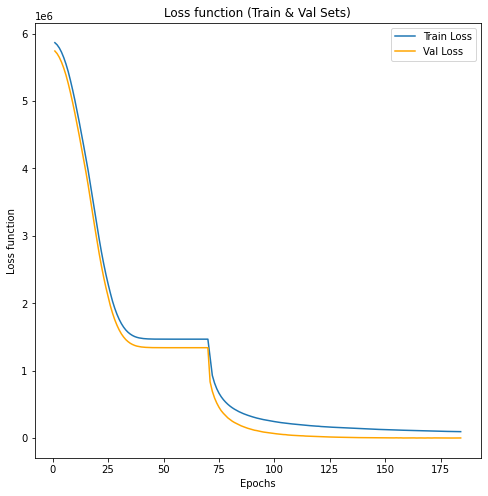

In [154]:
plt.figure(figsize=(8,8))
loss_function = regressor_history.history['loss']
val_loss_function = regressor_history.history['val_loss']
epochs = range(1,len(loss_function)+1)

plt.title('Loss function (Train & Val Sets)')
plt.plot(epochs,loss_function,label='Train Loss')
plt.plot(epochs,val_loss_function,color='orange',label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.legend()

In [155]:
probs = regressor_4.predict(X_test)
truth = y_test

64/64 [==============================] - 0s 916us/step


In [156]:
mse = round(mean_squared_error(probs, truth), 3)
mae = round(mean_absolute_error(probs, truth), 3)
r2 = round(r2_score(probs, truth), 5)
df_metrics_regress.loc[len(df_metrics_regress.index)] = ['fourth_model', mse, mae, r2] 

In [157]:
df_metrics_regress

,model,mse,mae,r2
0,base_model,6439.512,51.051,0.99453
1,second_model,1658.268,28.584,0.99859
2,third_model,1169.393,6.070,0.99900
3,fourth_model,2050.751,30.916,0.99823


Анализируя полученные метрики 4-х моделей, можно сделать вывод, что наилучшим регрессором является Third Model.

### Вывод

Набор данных 'DS_2019_public.csv' изначально не содержал пропущенных значений. Столбцы типа object состояли из числовых значений, поэтому мы перевели данные в них в float, а при невозможности такого преобразования удаляли строки с выбросами. В некоторых столбцах были выбросы в виде отрицательных значений. После удаления этих значений появились столбцы с NaN. Cтолбцы с процентом NaN больше 5% мы удалили, а в остальных столбцах удалили строки с пропущенными значениям. Дубликатов нет.

Среди четырёх моделей регрессоров лучше всего сработала Third Model. В ней увеличено число слоёв и нейронов на каждом слое по сравнению с Base Model, но не использовался Dropout(0.1).

Оценка качества регрессоров происходила по следующим метрикам: MSE, MAE и R2. Первые два показателя у Third Model нижу, чем у остальных моделей, а последний - выше.